<a href="https://colab.research.google.com/github/rosanmohan/UPI-Transaction-Forecasting/blob/main/UPI_Transaction_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the required modules

In [153]:
# For data analysis and functinality.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format


# To see the plots in some figure size range.
from pylab import rcParams
rcParams['figure.figsize']=30,13

# To ignore all warnings.
import warnings
warnings.filterwarnings('ignore')


from tqdm import tqdm




# !pip install pmdarima --quiet

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt


# Auto Arima
# !pip install pmdarima --quiet
import pmdarima as pm

# For the Deep learning model.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# For Darts models.

# !pip install darts --quiet

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel, ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape, smape, rmse
from darts.models import RNNModel



# For Prophet models.
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly



# For evaluation.
import math
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error



# For matplotlib.
!pip install matplotlib==3.1.3 --quiet

# Data loading.

In [135]:
df=pd.read_excel('/content/drive/MyDrive/Projects/UPI_Transactions/Daily_upi_trans/Daily_upi_trans_value.xlsx')

In [3]:
df.head()

Day  Value (crores)
0 2021-05-01        18140.21
1 2021-05-02        13692.47
2 2021-05-03        20191.07
3 2021-05-04        20005.02
4 2021-05-05        19438.15

In [4]:
df.columns=['date','value']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    622 non-null    datetime64[ns]
 1   value   622 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.8 KB


In [6]:
data=df.set_index('date')

# EDA

In [7]:
data.isna().sum()

value    0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 622 entries, 2021-05-01 to 2023-01-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   622 non-null    float64
dtypes: float64(1)
memory usage: 9.7 KB


In [9]:
data.head()

value
date               
2021-05-01 18140.21
2021-05-02 13692.47
2021-05-03 20191.07
2021-05-04 20005.02
2021-05-05 19438.15

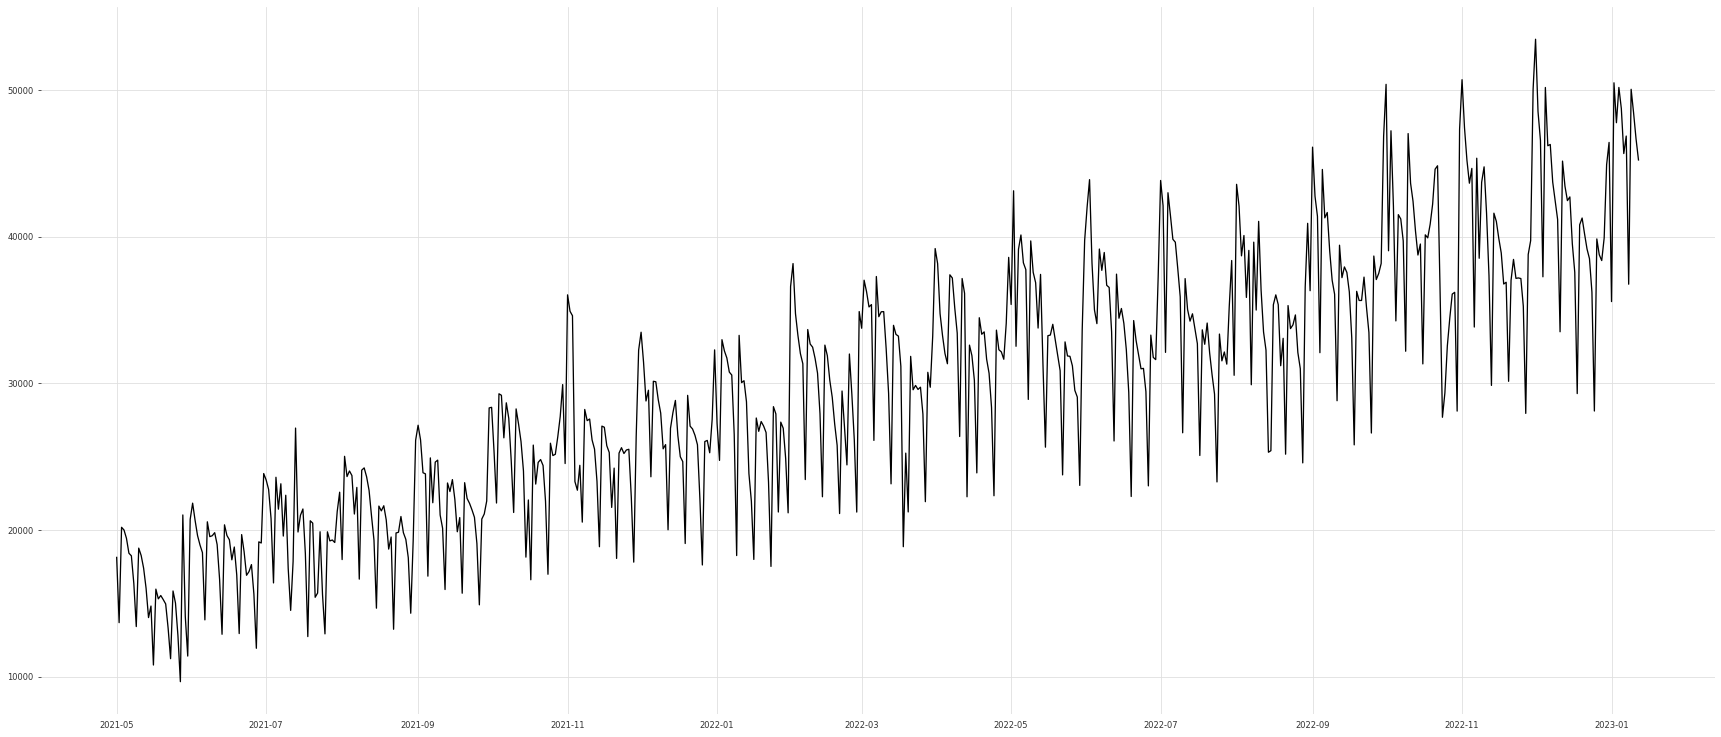

In [14]:
# plt.figure(figsize = (15,5))
# data['value'].plot();
plt.plot(data['value'])

# Arima Model.

In [25]:
data_arima=data.copy(deep=True)

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

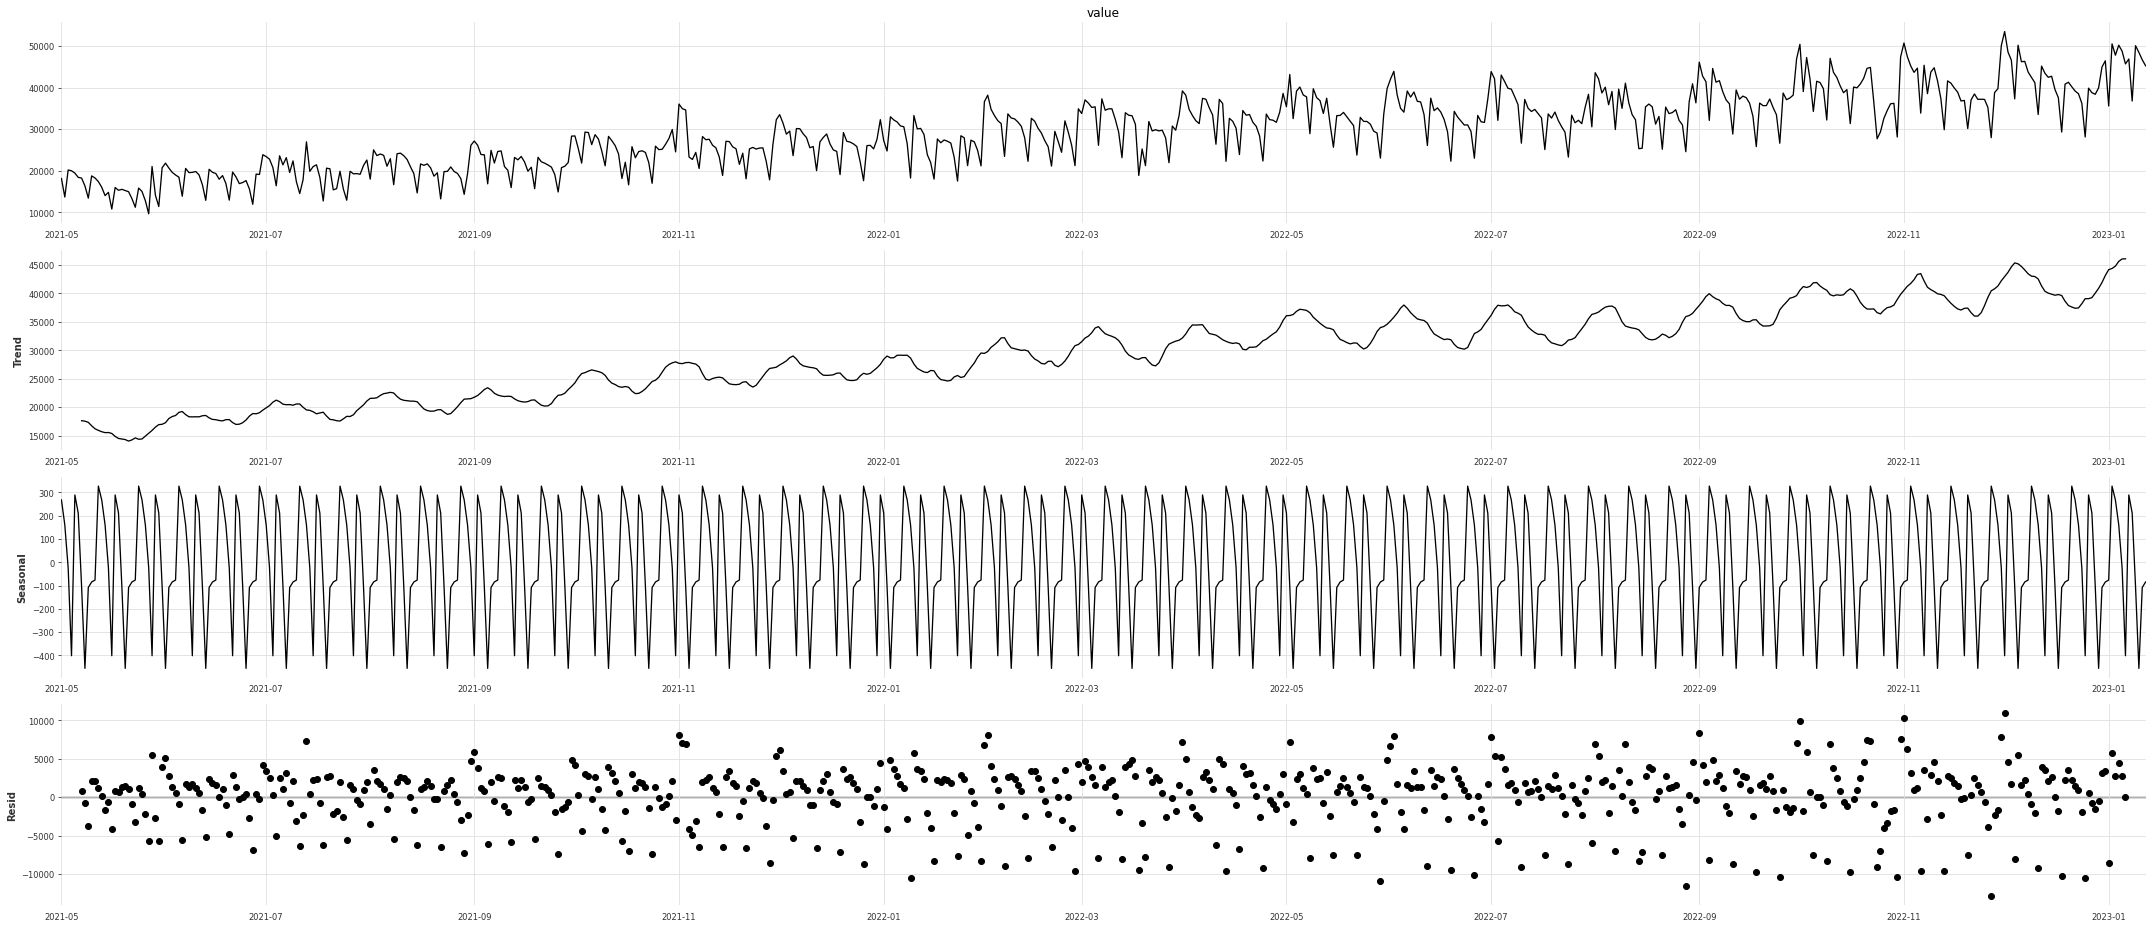

In [15]:
dec = smt.seasonal_decompose(data['value'],period = 12,model = 'additive').plot()
plt.show()

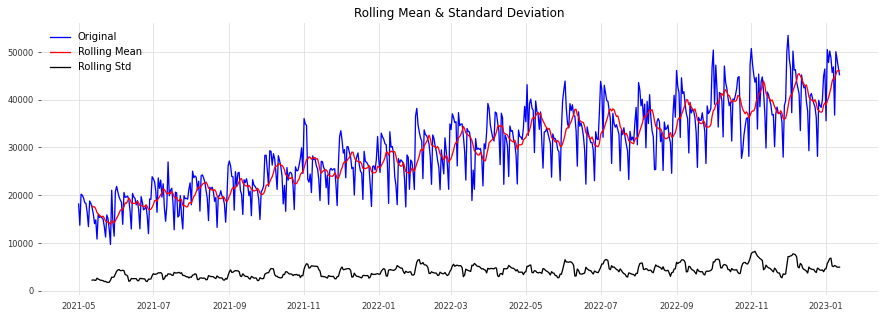

Results of Dickey-Fuller Test:
Test Statistic                 -1.12
p-value                         0.71
#Lags Used                     19.00
Number of Observations Used   602.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [16]:
test_stationarity(data['value'])

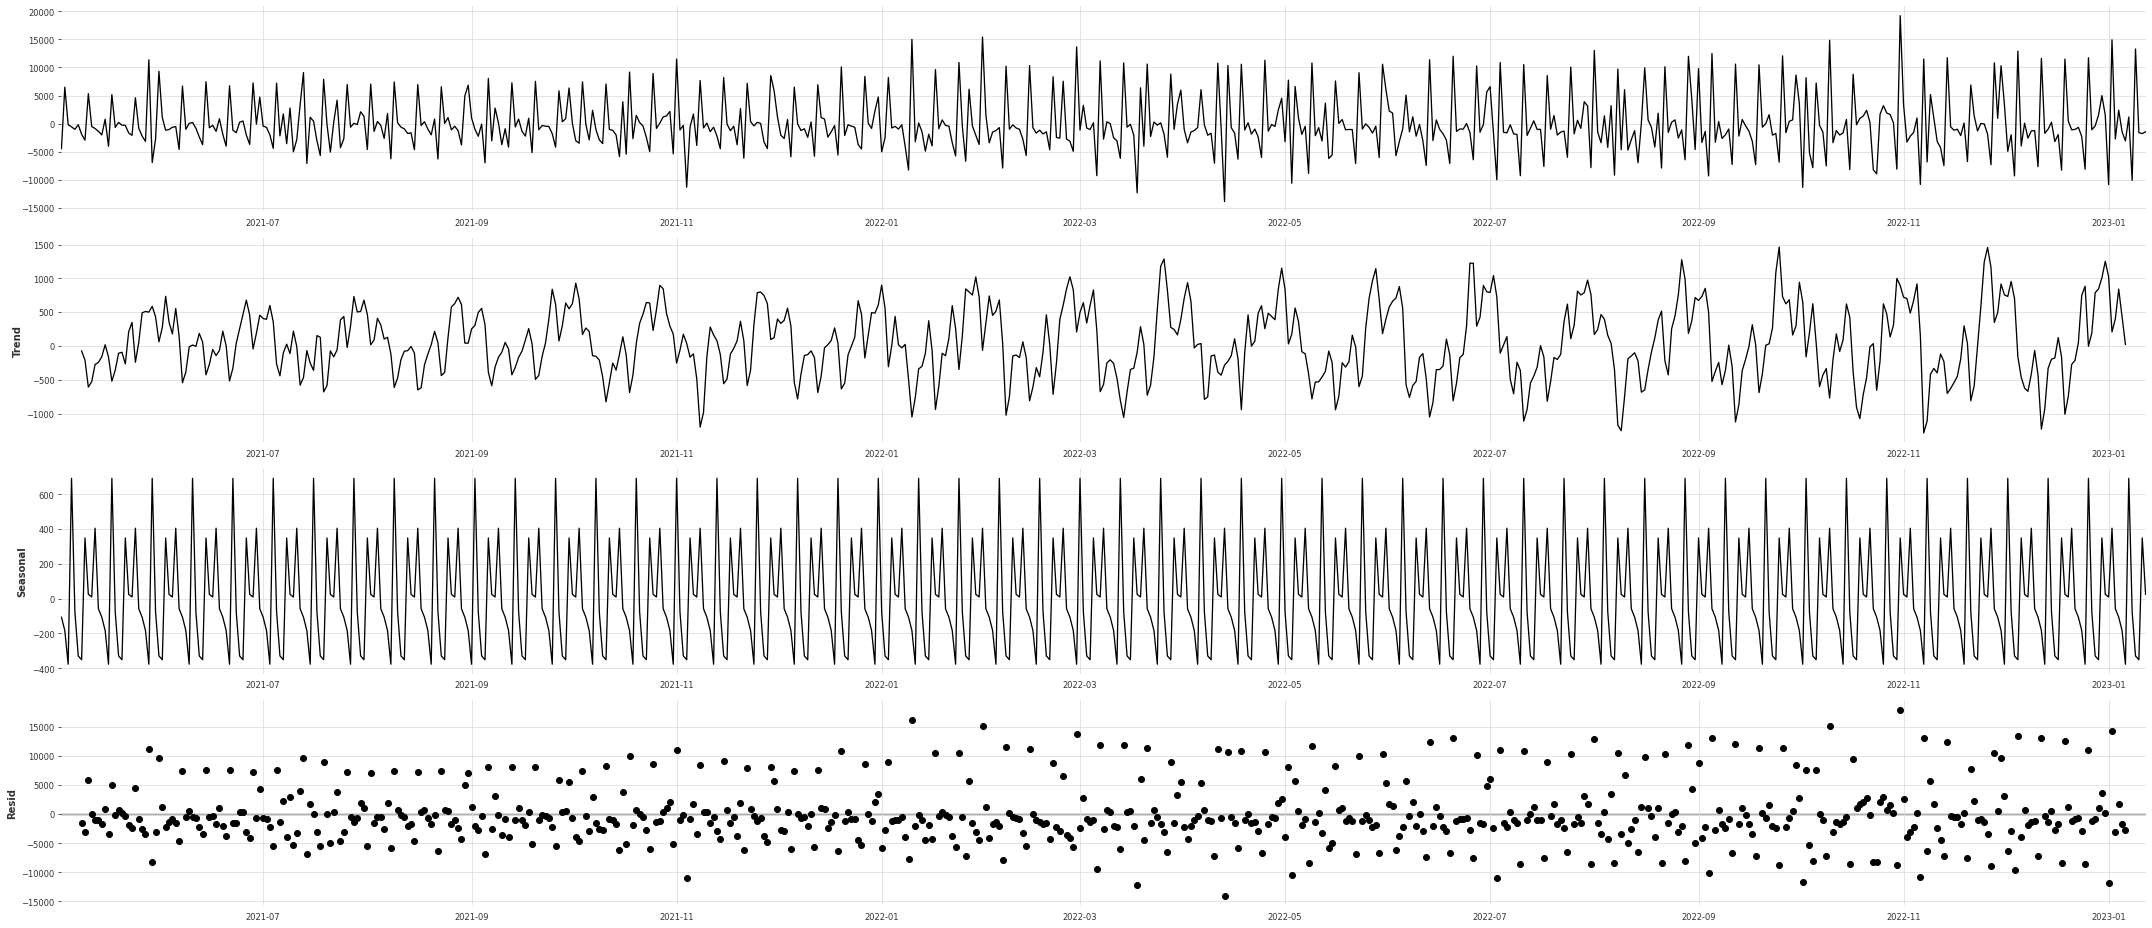

In [17]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = smt.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

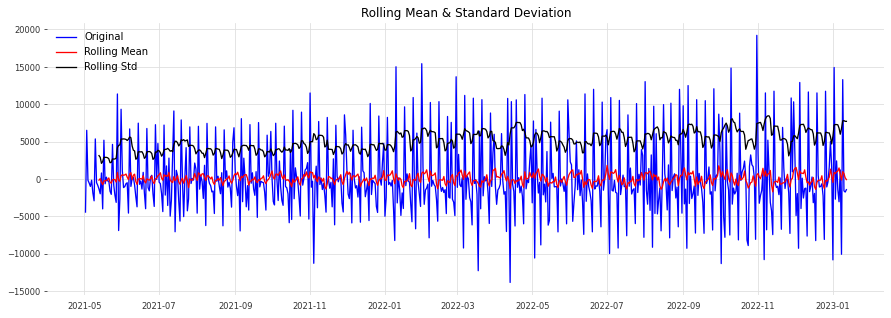

Results of Dickey-Fuller Test:
Test Statistic                -11.87
p-value                         0.00
#Lags Used                     19.00
Number of Observations Used   601.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [18]:
test_stationarity(data_diff)

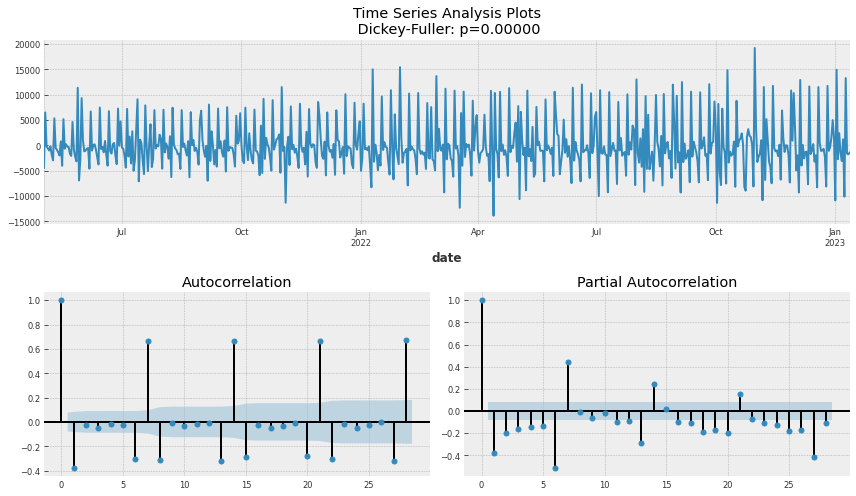

In [19]:
tsplot(data_diff['value'])

In [20]:
arima_model = ARIMA(data_diff,order = (7,0,1))
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  # If an index is available, see if it is a date-based index or if it
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  # If an index is available, see if it is a date-based index or if it
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  # If an index is available, see if it is a date-based index or if it


In [21]:
arima_fitted_values = arima_model_fit.fittedvalues

In [ ]:
# pd.options.display.float_format = '{:.2f}'.format
# from sklearn.metrics import mean_absolute_percentage_error
# mape = mean_absolute_percentage_error(data_diff,arima_fitted_values)
# print(f"mean absolute percentage error is: {mape:.2f}")

Root mean squred error is: 3421.45
mean absolute percentage error is: 3.66


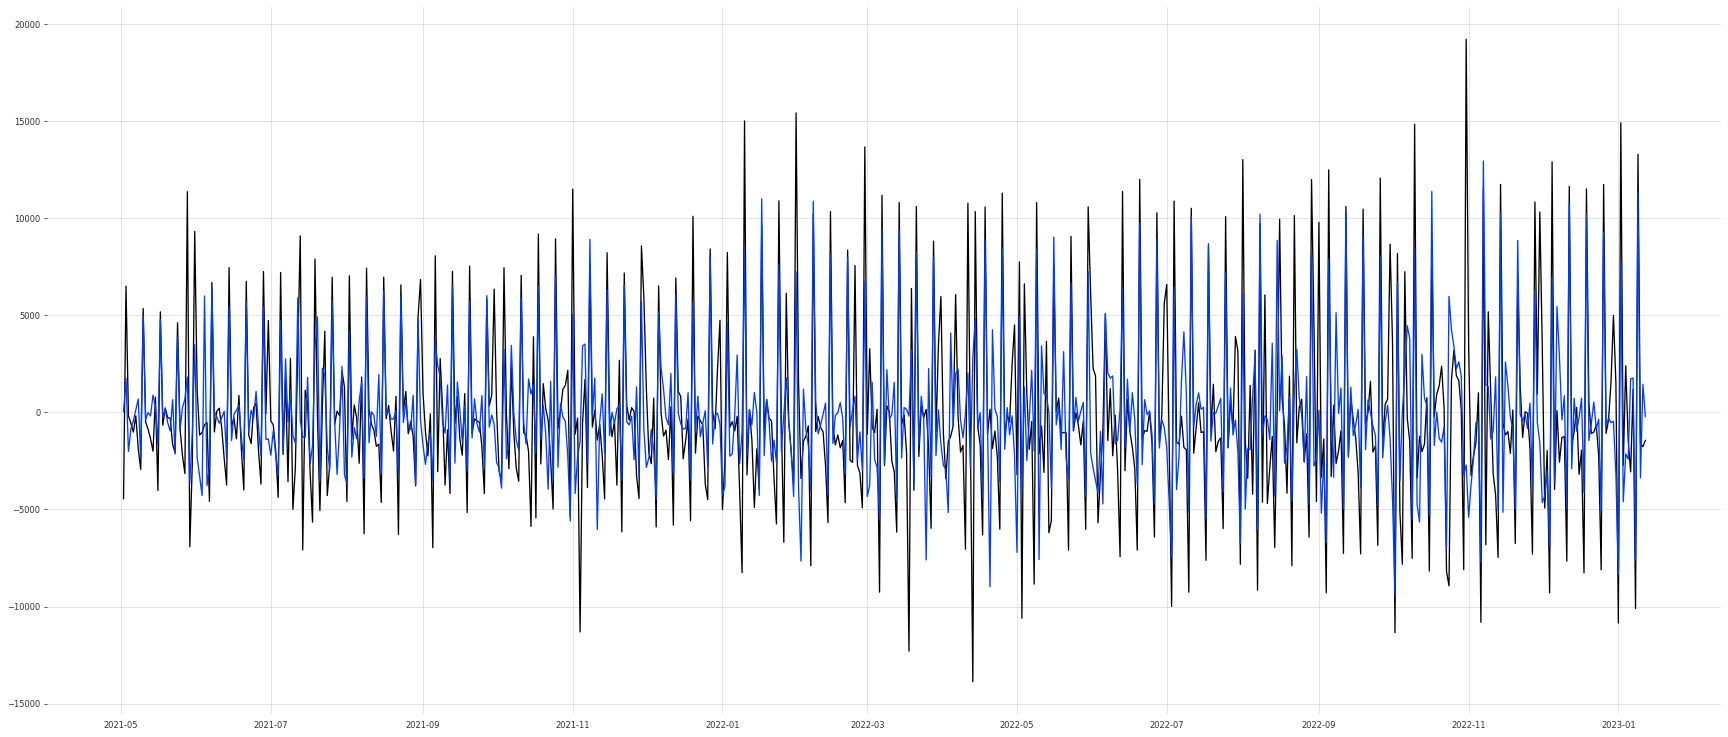

In [35]:
plt.plot(data_diff)
plt.plot(arima_fitted_values)

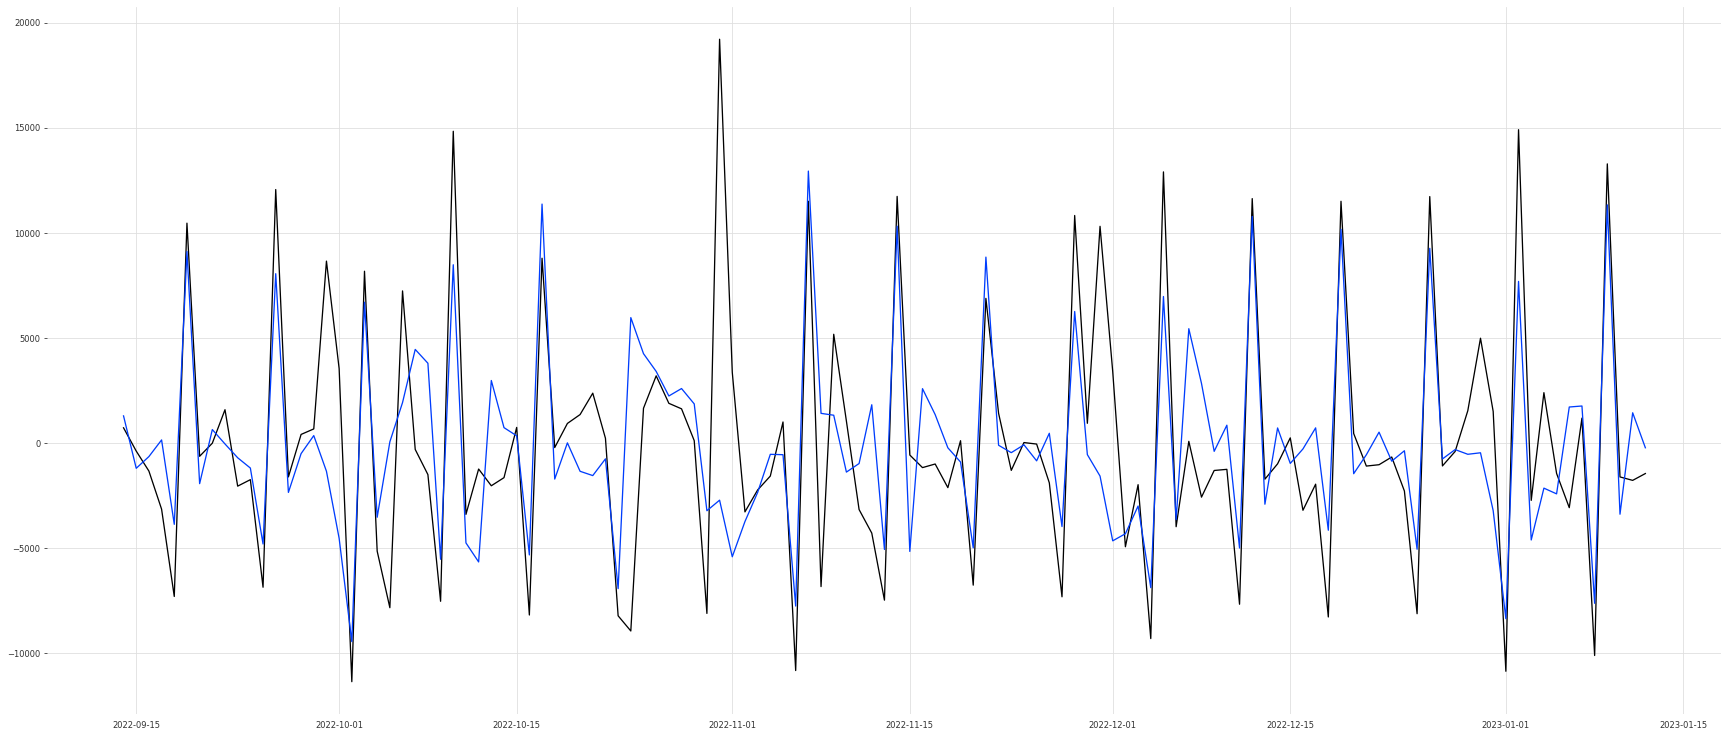

In [36]:
plt.plot(data_diff[500:])
plt.plot(arima_fitted_values[500:])

In [37]:
arima_diff_prediction=arima_model_fit.predict(start=len(data_diff), end=len(data_diff)+30)

In [38]:
arima_prediction=np.cumsum(arima_diff_prediction) + data.iloc[-1,0]

In [39]:
data.tail()

value
date               
2023-01-08 36760.43
2023-01-09 50045.65
2023-01-10 48440.96
2023-01-11 46672.56
2023-01-12 45229.12

In [40]:
arima_prediction.head()

2023-01-13   44526.68
2023-01-14   46343.42
2023-01-15   39210.25
2023-01-16   48593.98
2023-01-17   46769.36
Freq: D, Name: predicted_mean, dtype: float64

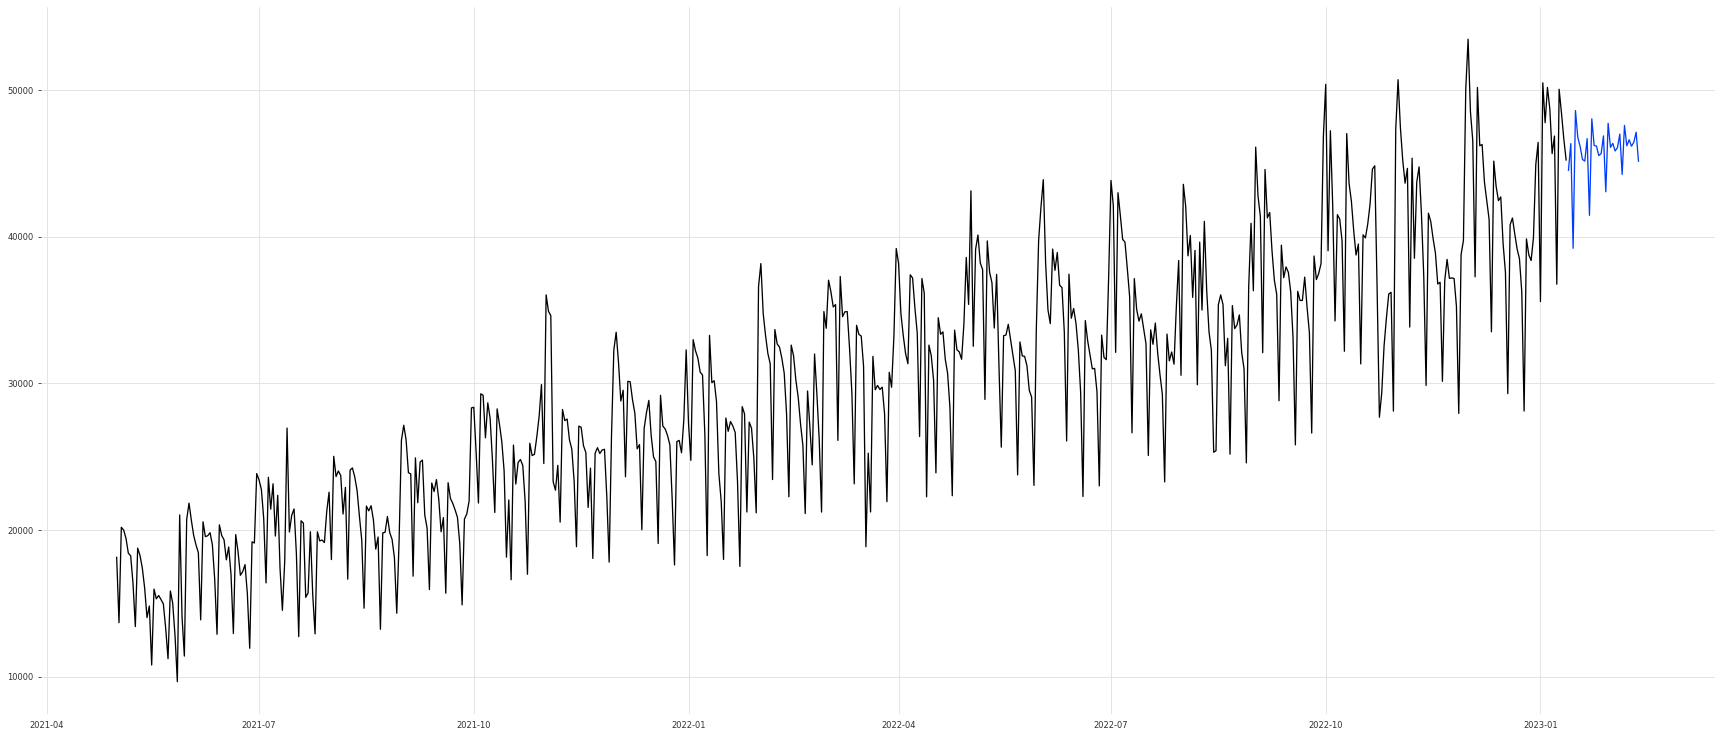

In [41]:
plt.plot(data)
plt.plot(arima_prediction)

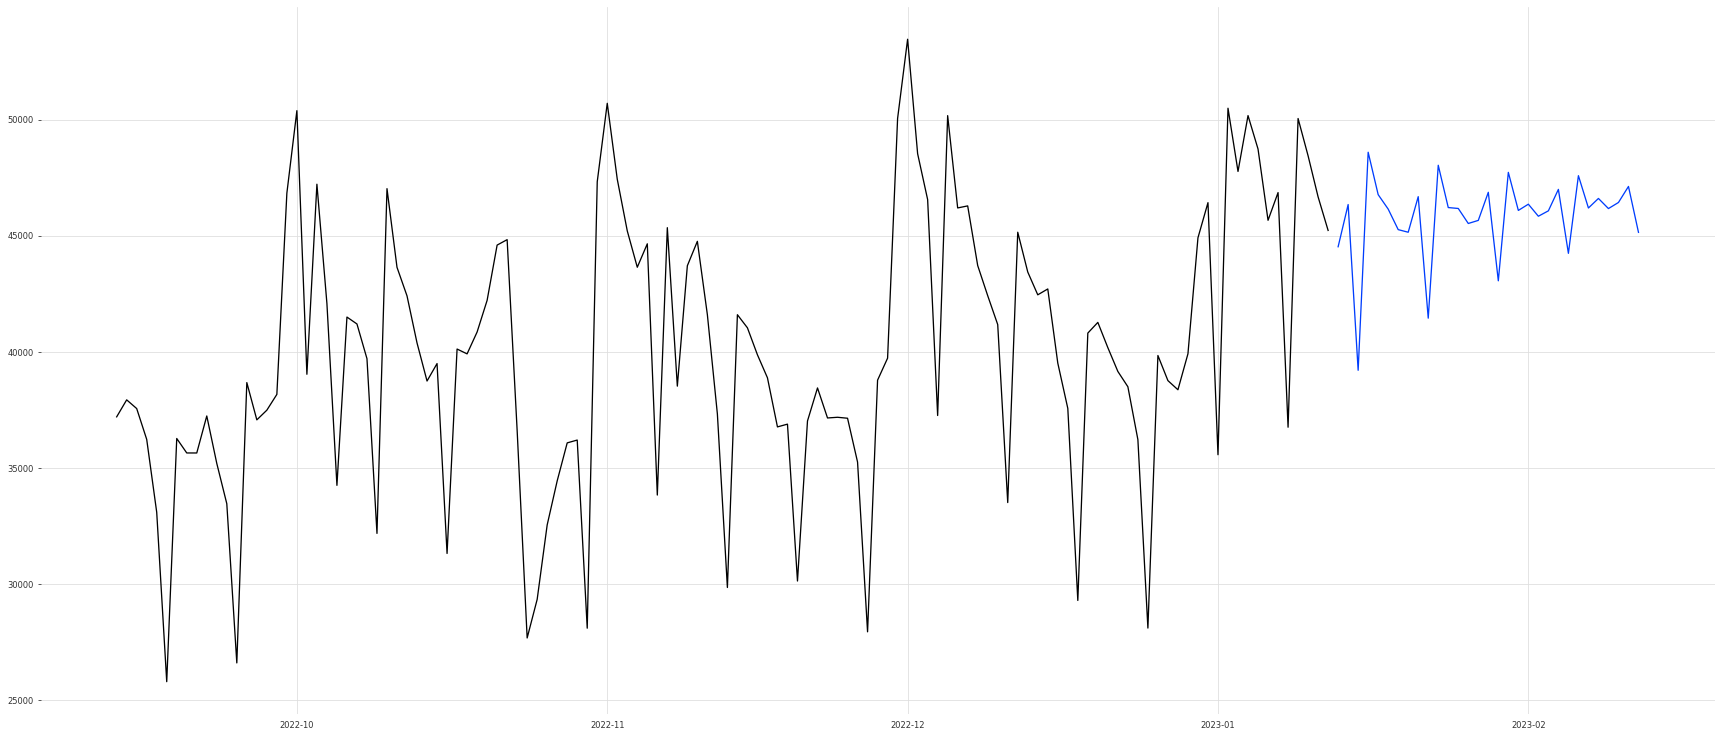

In [43]:
plt.plot(data[500:])
plt.plot(arima_prediction)

# Sarima Model.

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(data_diff, order=(7, 0, 1), seasonal_order=(7, 0, 1, 12))
sarima_model_fit = sarima_model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [74]:
sarima_fitted_values = sarima_model_fit.fittedvalues

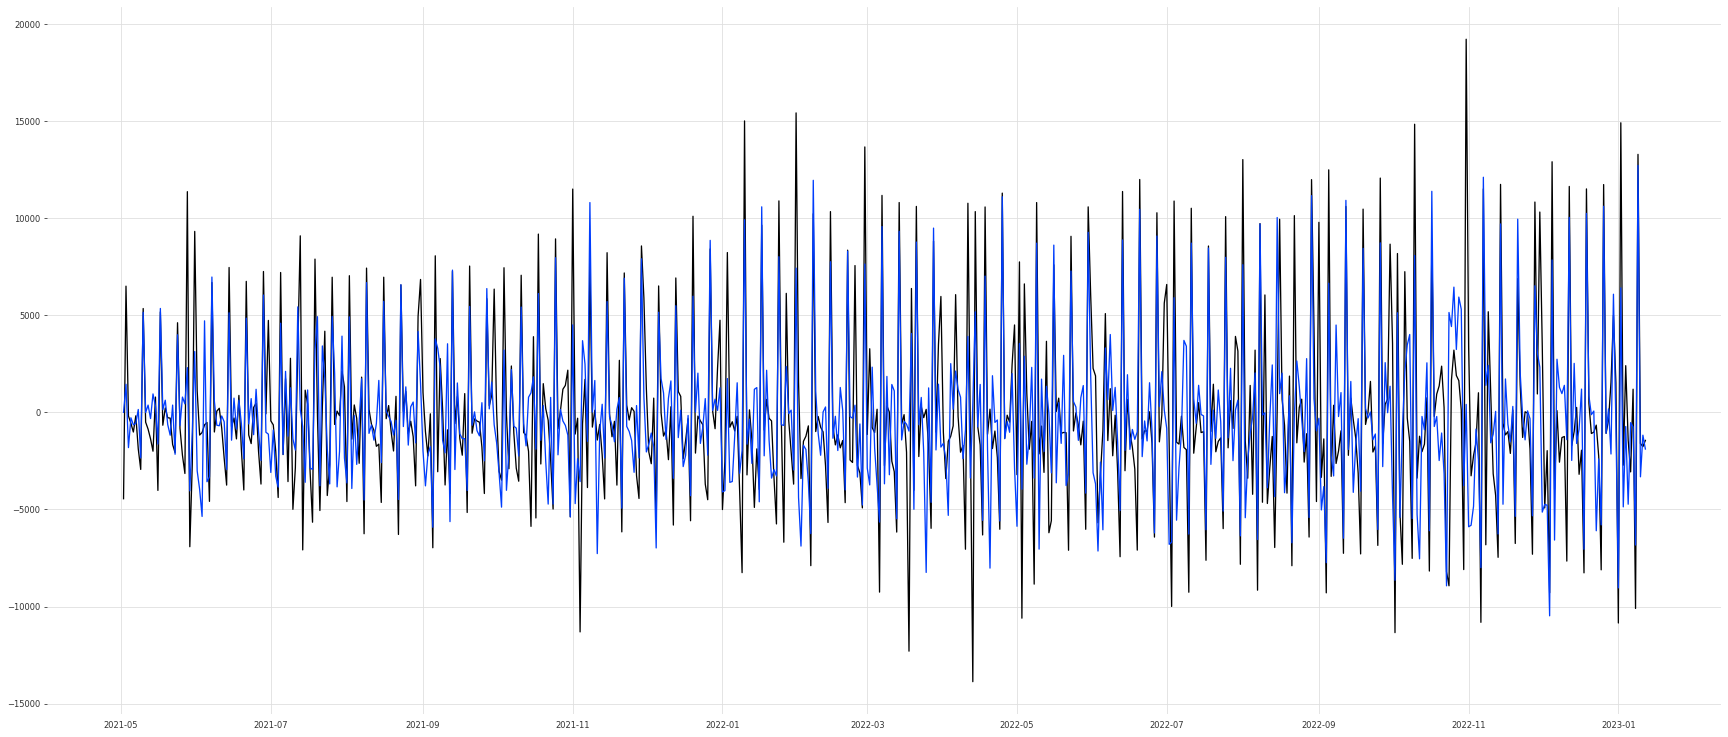

In [75]:
plt.plot(data_diff)
plt.plot(sarima_fitted_values)

In [76]:
sarima_diff_prediction=sarima_model_fit.predict(start=len(data_diff), end=len(data_diff)+30)

In [77]:
sarima_prediction=np.cumsum(sarima_diff_prediction) + data.iloc[-1,0]

In [78]:
data.tail()

value
date               
2023-01-08 36760.43
2023-01-09 50045.65
2023-01-10 48440.96
2023-01-11 46672.56
2023-01-12 45229.12

In [79]:
sarima_prediction.head()

2023-01-13   44856.59
2023-01-14   47168.95
2023-01-15   37896.74
2023-01-16   47370.11
2023-01-17   44125.63
Freq: D, Name: predicted_mean, dtype: float64

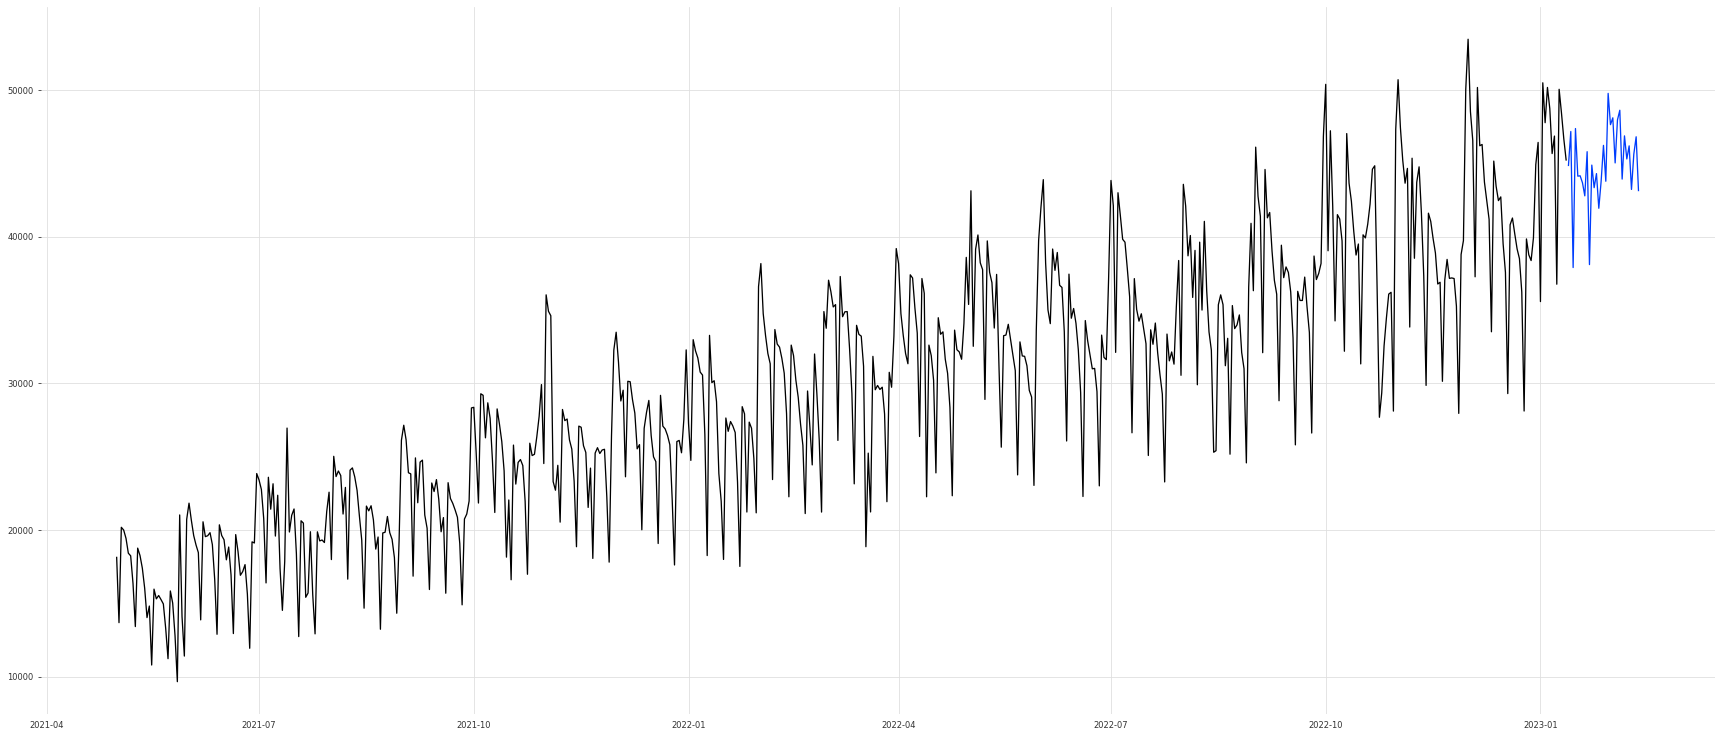

In [80]:
plt.plot(data)
plt.plot(sarima_prediction)

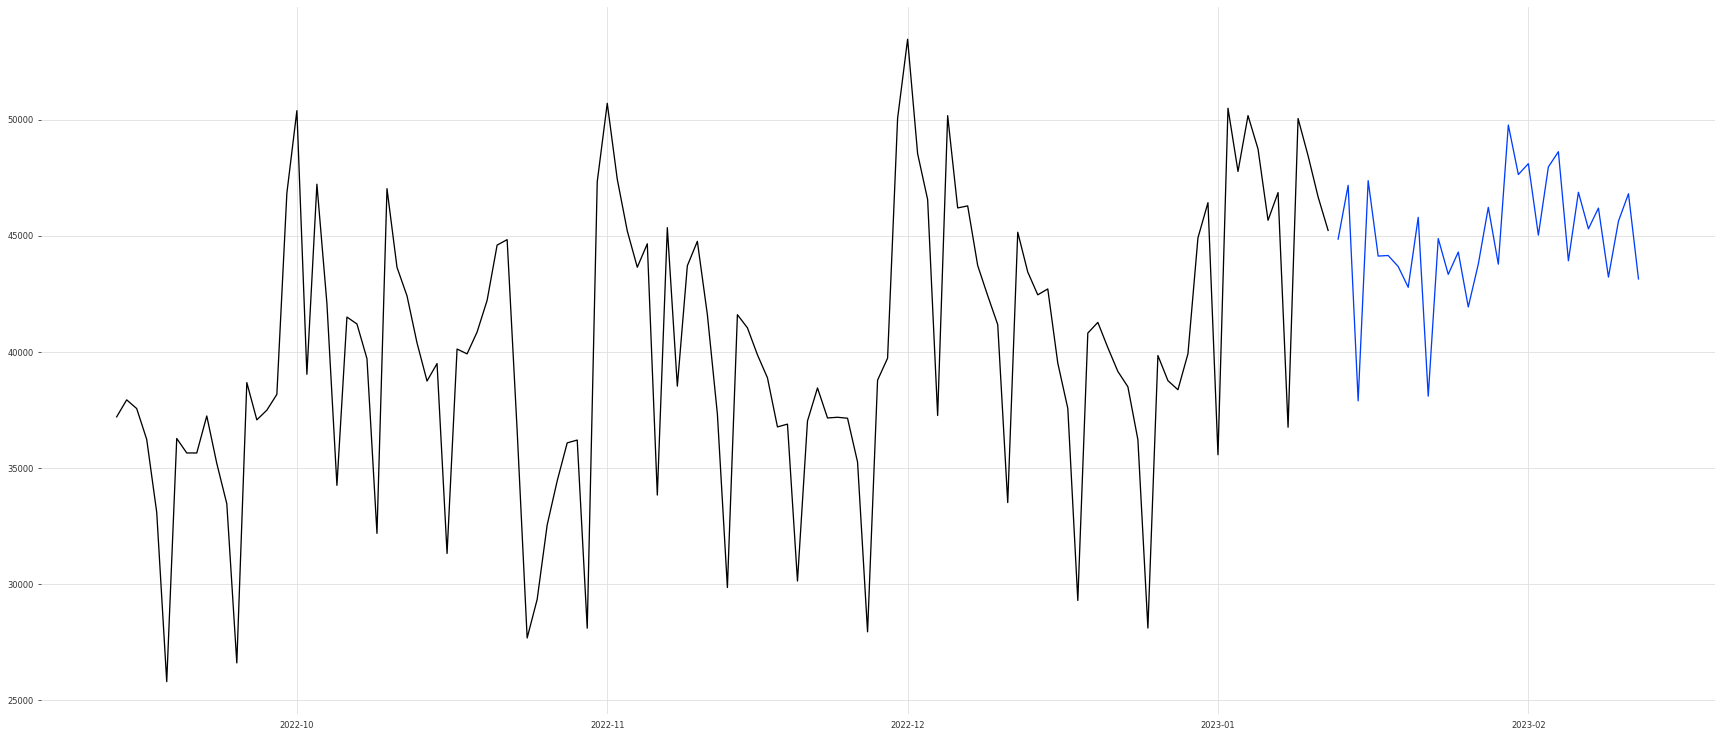

In [81]:
plt.plot(data[500:])
plt.plot(sarima_prediction)

# Auto arima Model.

AutoArima model with seasonal false on statioary data

In [83]:
# !pip install pmdarima --quiet
import pmdarima as pm
first_auto_arima_model=pm.auto_arima(data_diff['value'], seasonal=False, suppress_warnings=True, stepwise=True, error_action="ignore", trace=True, stationary=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12356.880, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12263.236, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12200.490, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12354.927, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12198.782, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12168.268, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12261.351, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12163.328, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12239.522, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12165.321, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1

In [84]:
first_auto_arima_model_fit=first_auto_arima_model.fit(data_diff['value'])

In [85]:
first_auto_arima_diff_pred_value= first_auto_arima_model_fit.predict(n_periods=30)

In [86]:
first_auto_arima_pred_value=np.cumsum(first_auto_arima_diff_pred_value) + data.iloc[-1,0]

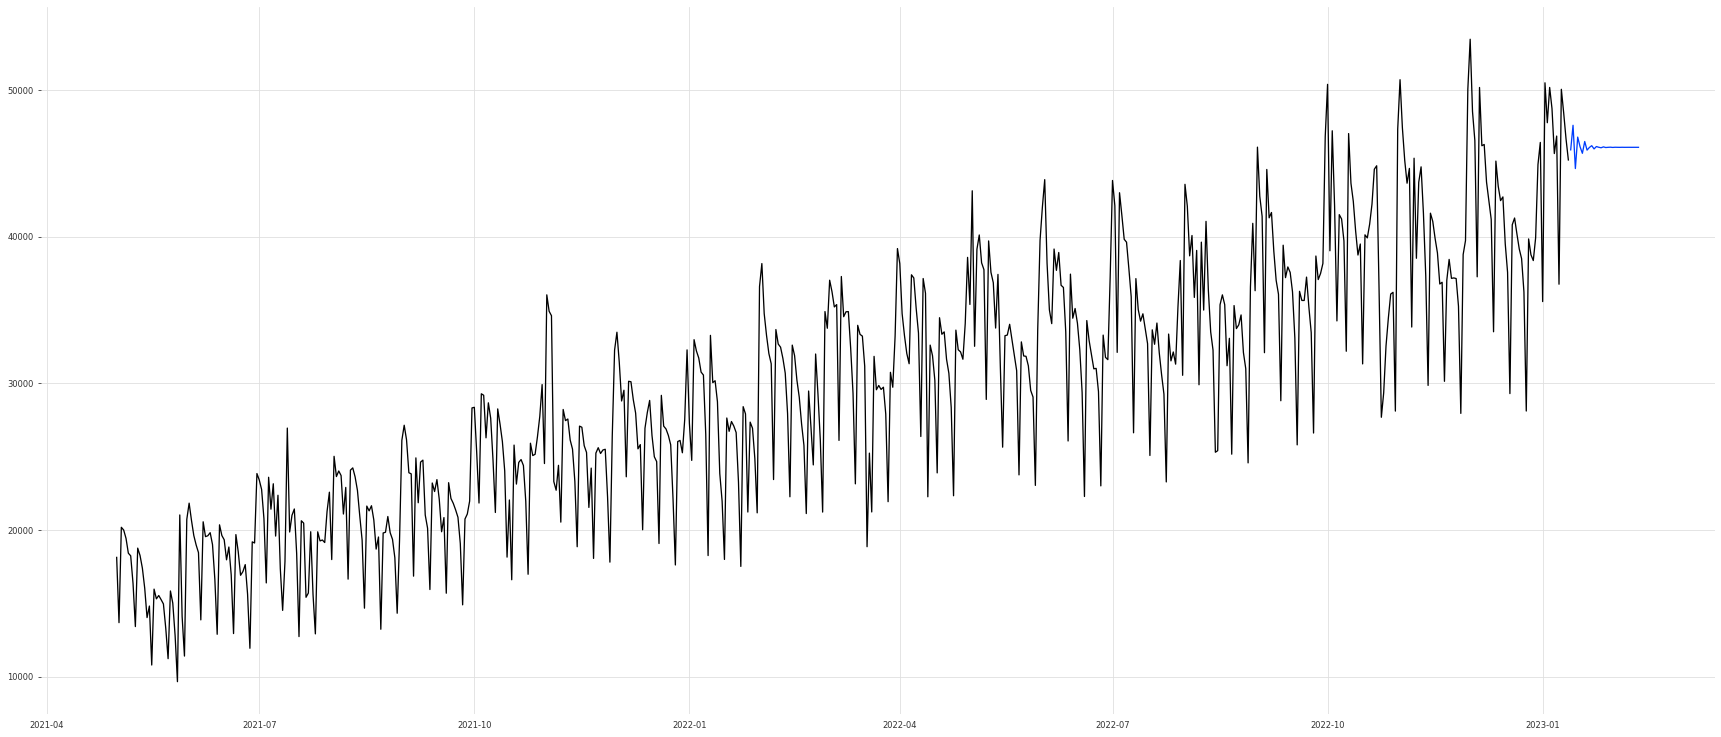

In [87]:
plt.plot(data)
plt.plot(first_auto_arima_pred_value)

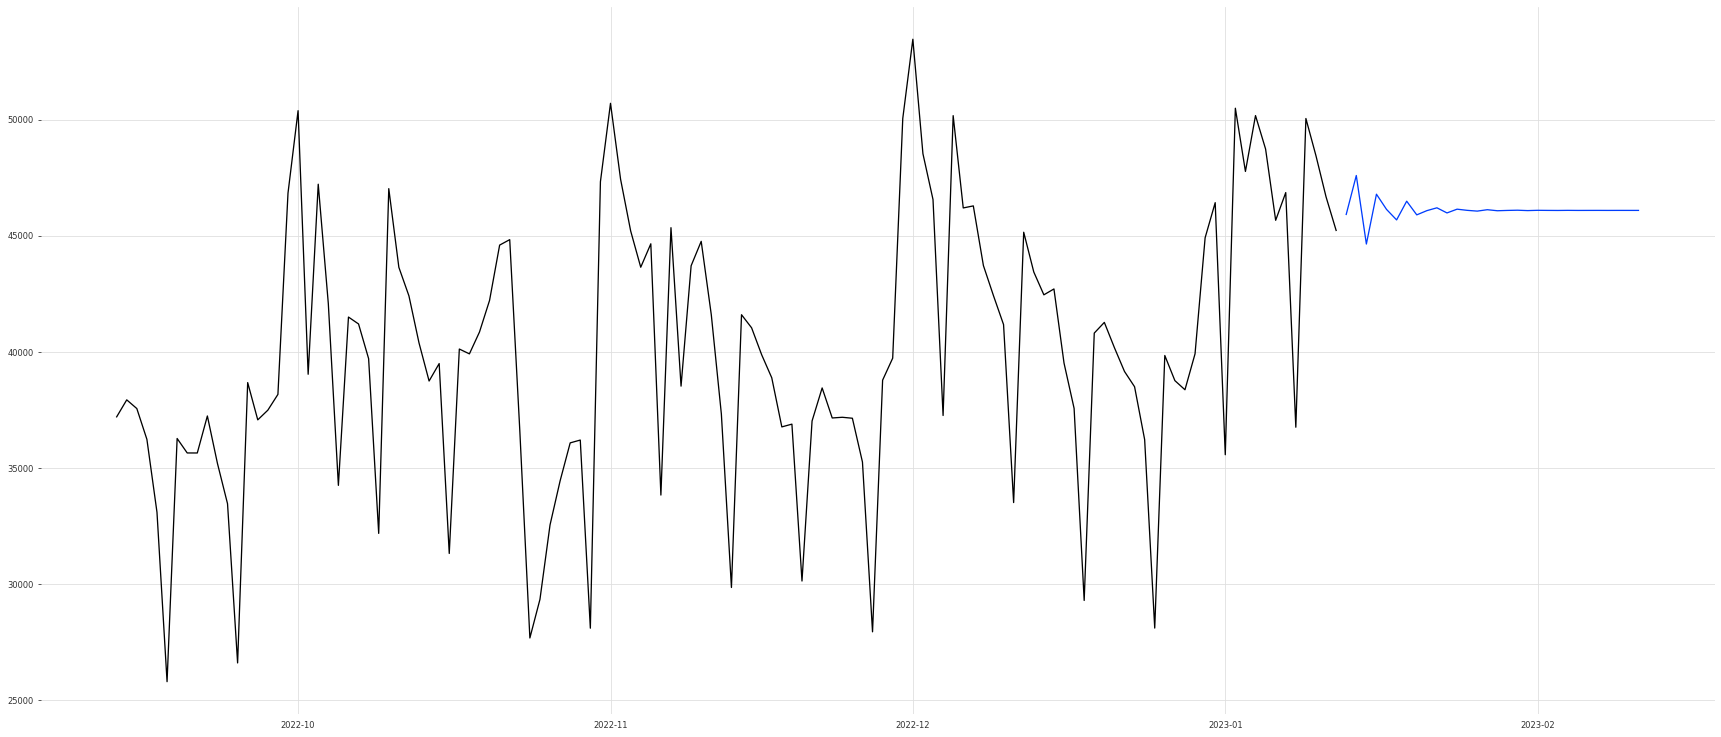

In [88]:
plt.plot(data[500:])
plt.plot(first_auto_arima_pred_value)

AutoArima model with seasonal True on statioary data

In [89]:
second_auto_arima_model=pm.auto_arima(data_diff['value'], seasonal=True, suppress_warnings=True, stepwise=True, error_action="ignore", trace=True, stationary=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12356.880, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12263.236, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12200.490, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12354.927, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12198.782, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12168.268, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12261.351, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12163.328, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12239.522, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12165.321, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1

In [90]:
second_auto_arima_model_fit=second_auto_arima_model.fit(data_diff['value'])

In [91]:
second_auto_arima_diff_pred_value= second_auto_arima_model_fit.predict(n_periods=30)

In [92]:
second_auto_arima_pred_value=np.cumsum(second_auto_arima_diff_pred_value) + data.iloc[-1,0]

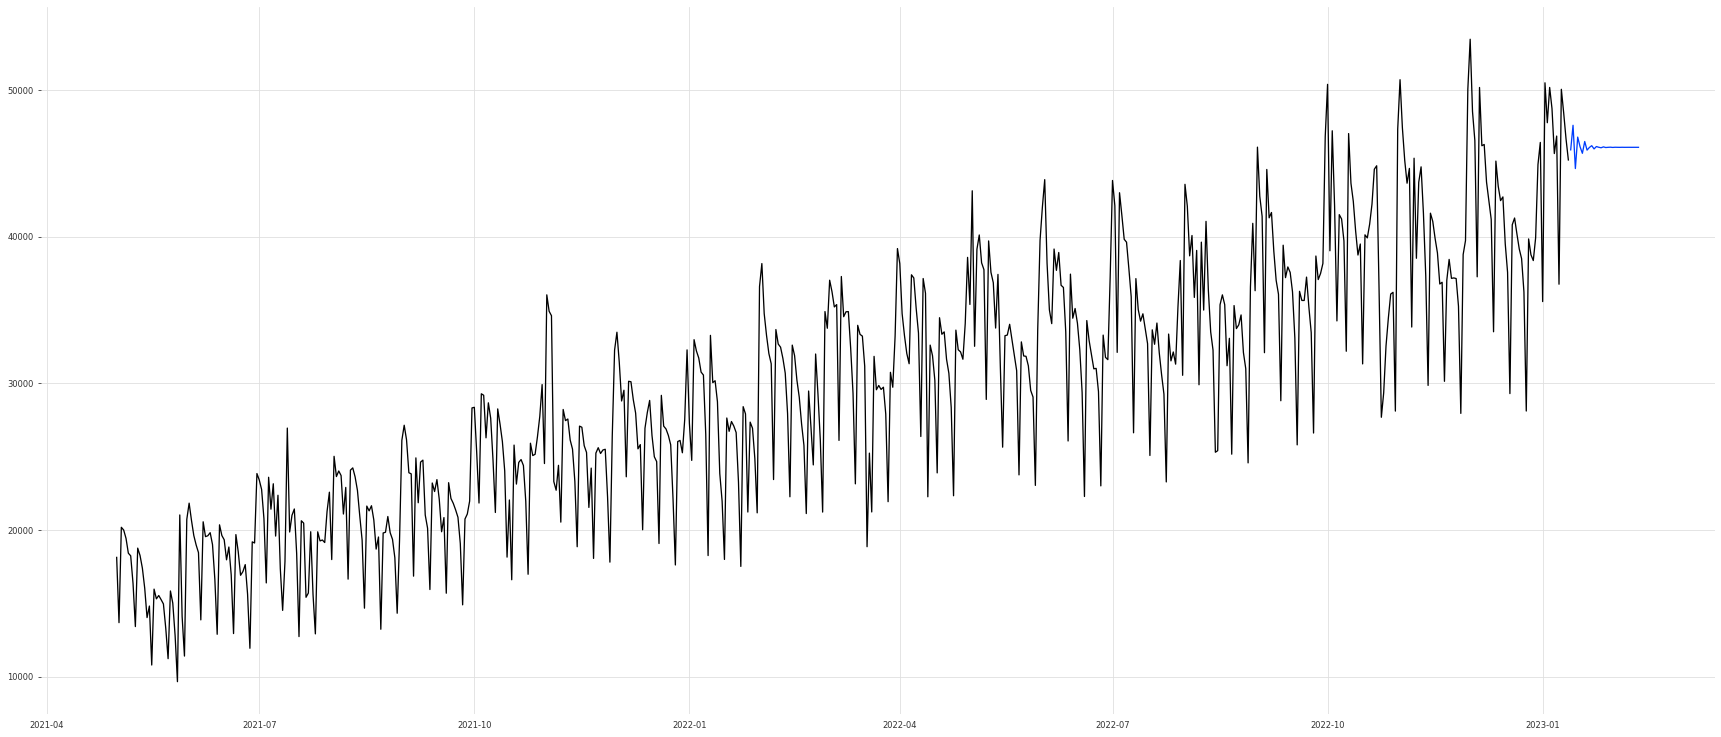

In [93]:
plt.plot(data)
plt.plot(second_auto_arima_pred_value)

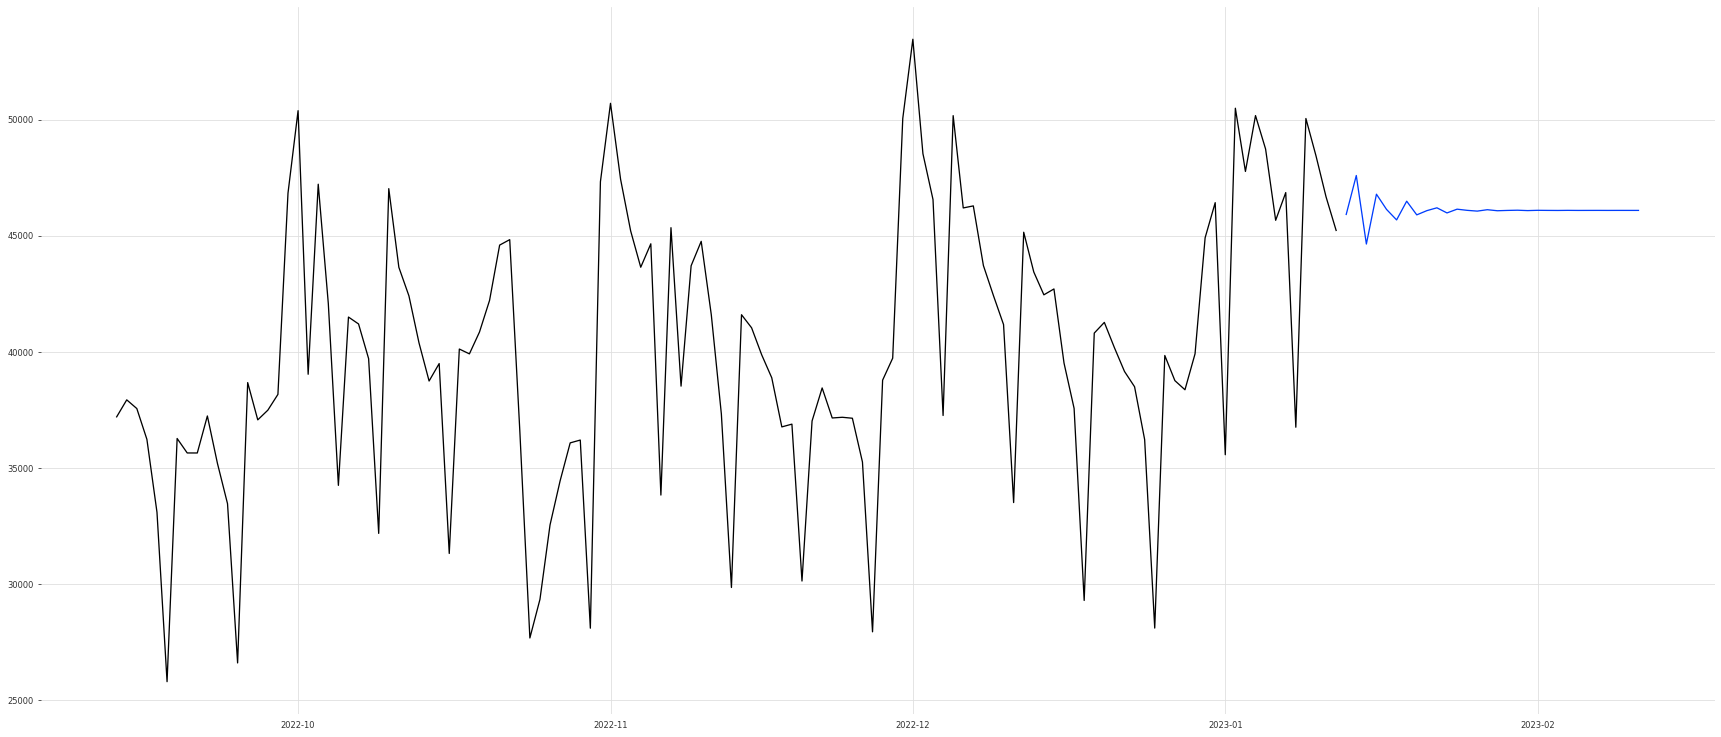

In [94]:
plt.plot(data[500:])
plt.plot(second_auto_arima_pred_value)

AutoArima model with seasonal false on non-statioary data

In [95]:
third_auto_arima_model=pm.auto_arima(data['value'], seasonal=False, suppress_warnings=True, stepwise=True, error_action="ignore", trace=True, stationary=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12356.880, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12262.488, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12203.435, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12354.927, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12189.483, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12187.095, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12201.984, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12162.542, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12170.701, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12162.9

In [96]:
third_auto_arima_model_fit=third_auto_arima_model.fit(data['value'])

In [97]:
third_auto_arima_pred_value=third_auto_arima_model_fit.predict(n_periods=30)

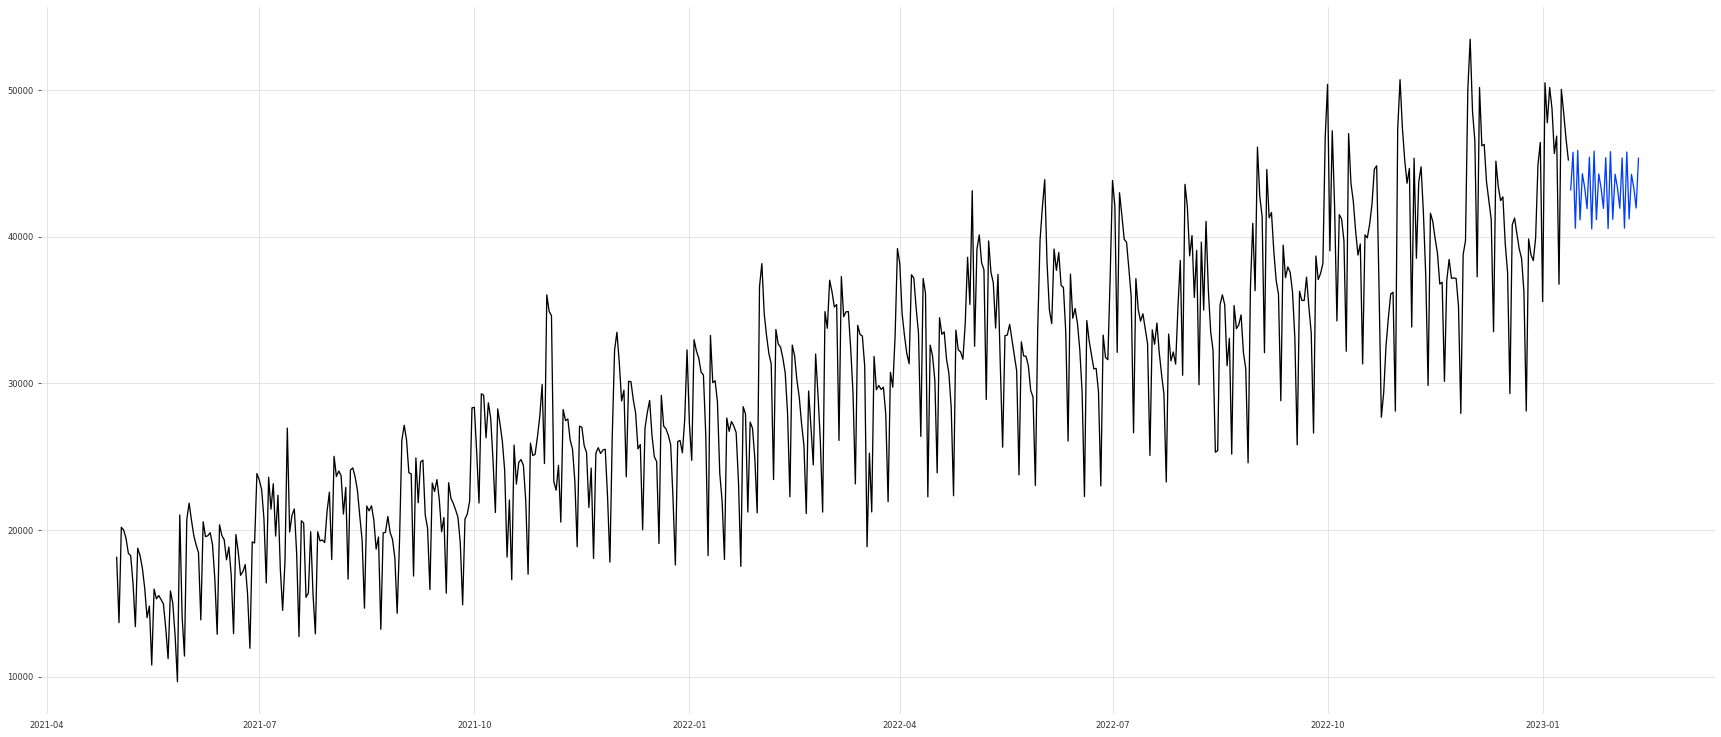

In [98]:
plt.plot(data)
plt.plot(third_auto_arima_pred_value)

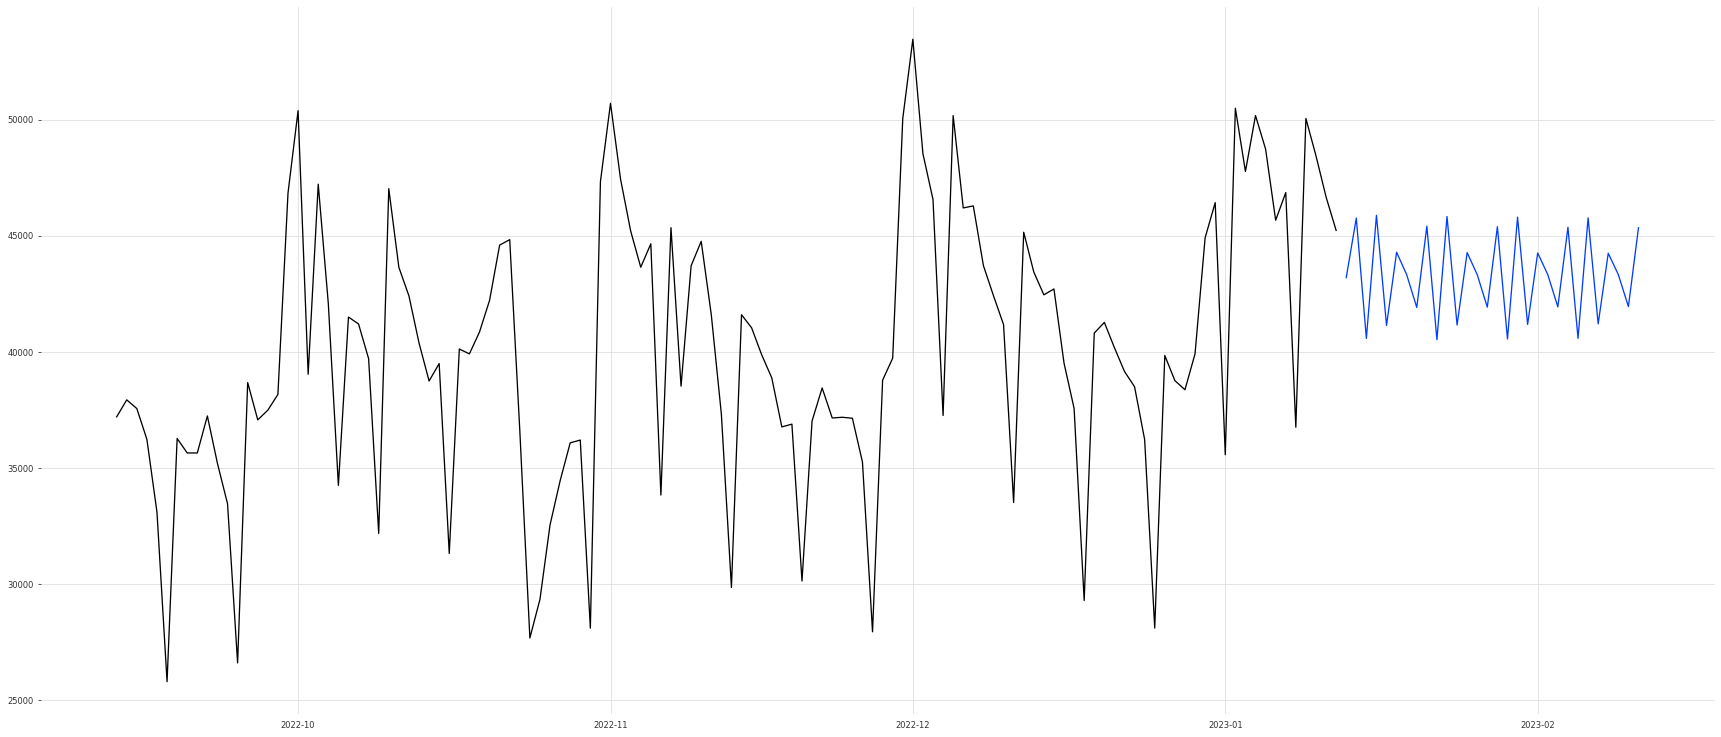

In [99]:
plt.plot(data[500:])
plt.plot(third_auto_arima_pred_value)

AutoArima model with seasonal True on non-statioary data

In [100]:
fourth_auto_arima_model=pm.auto_arima(data['value'], seasonal=True, suppress_warnings=True, stepwise=True, error_action="ignore", trace=True, stationary=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12356.880, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12262.488, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12203.435, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12354.927, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12189.483, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12187.095, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12201.984, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12162.542, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12170.701, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12162.9

In [101]:
fourth_auto_arima_model_fit=fourth_auto_arima_model.fit(data['value'])

In [102]:
fourth_auto_arima_pred_value=fourth_auto_arima_model_fit.predict(n_periods=30)

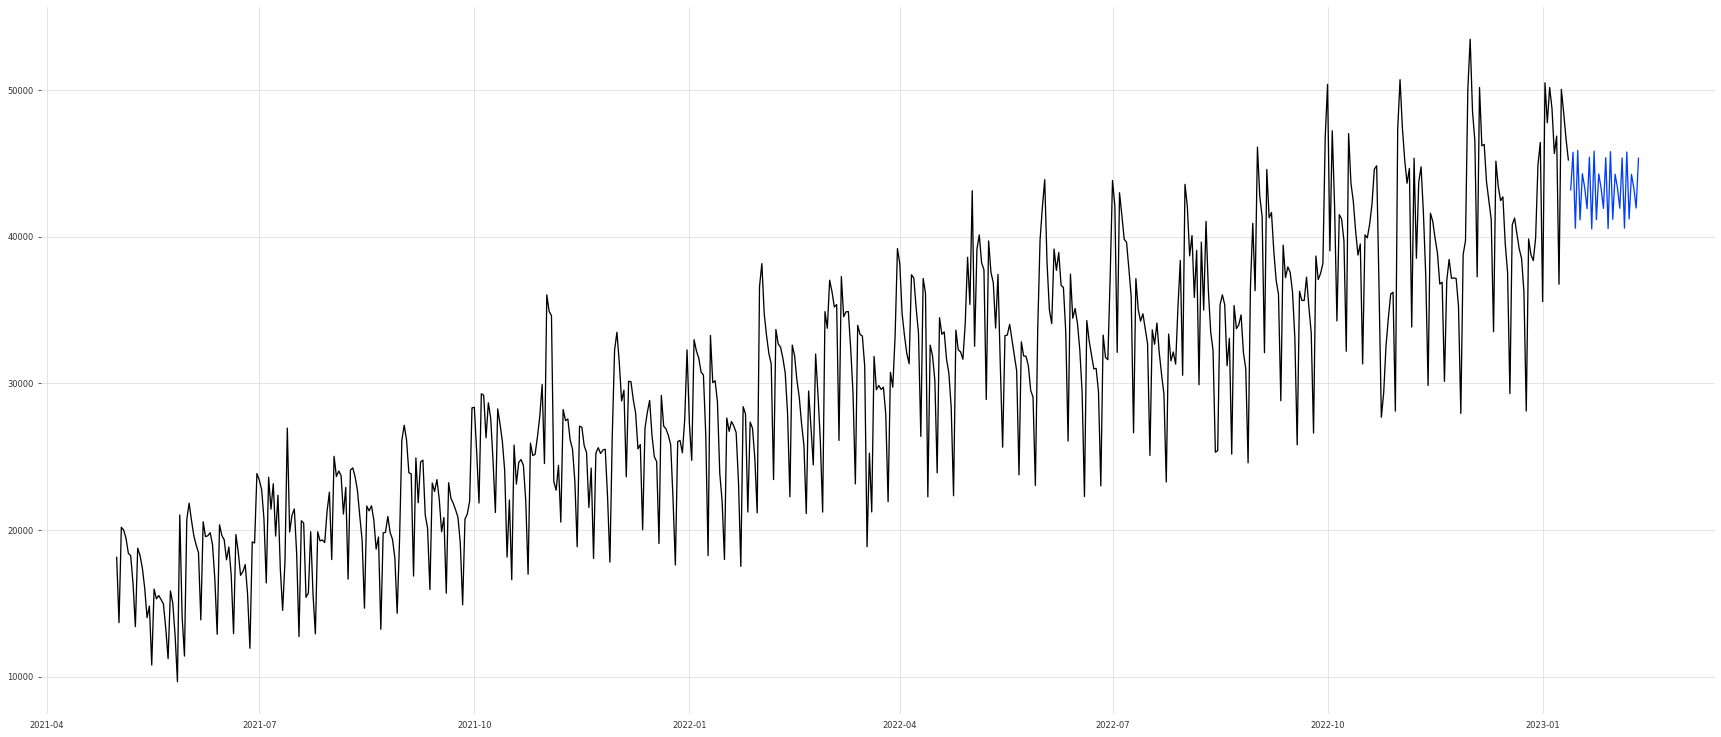

In [103]:
plt.plot(data)
plt.plot(fourth_auto_arima_pred_value)

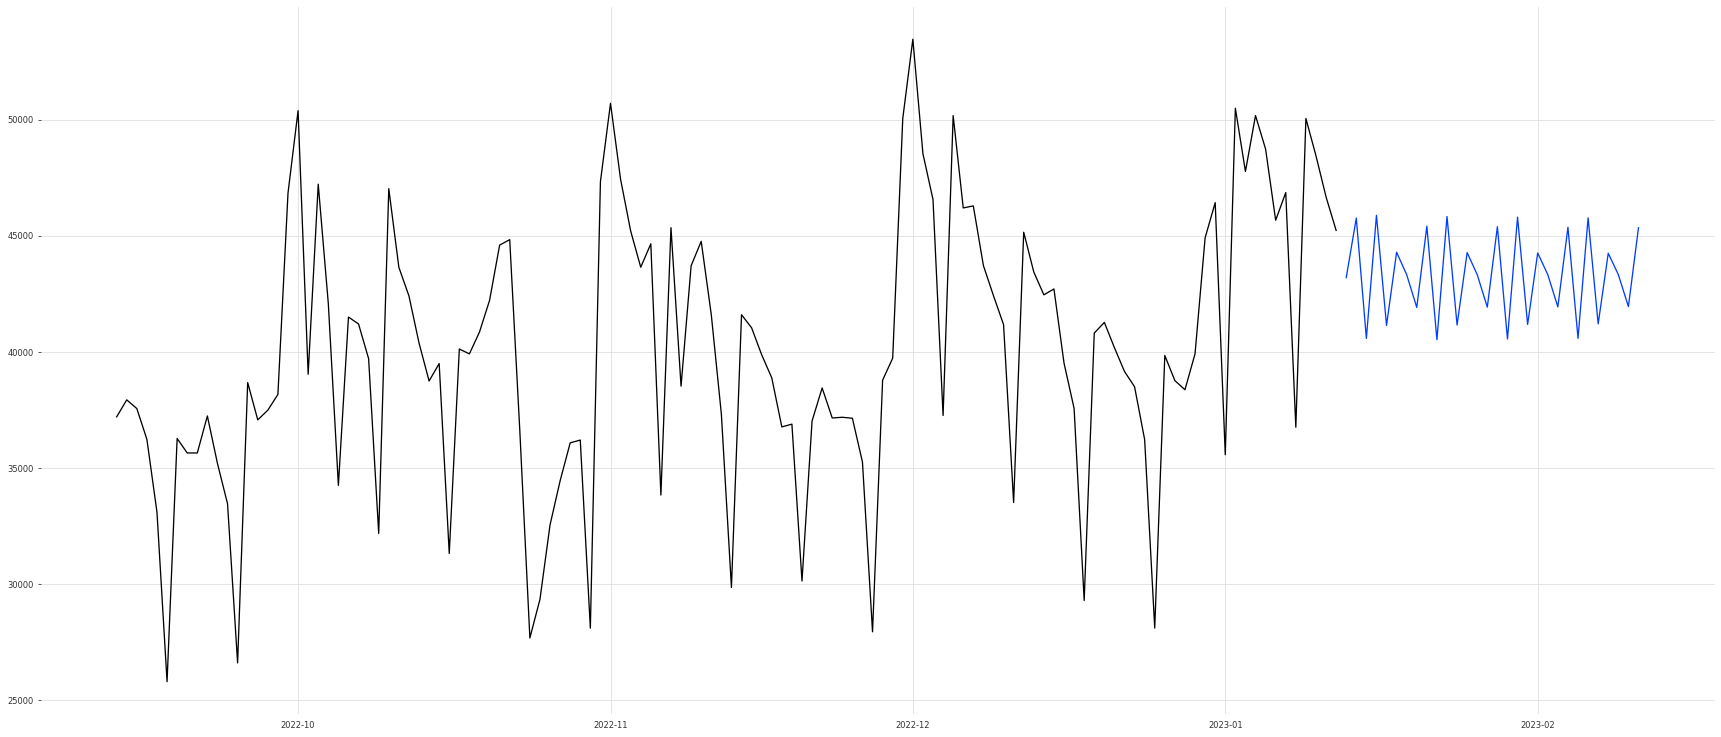

In [104]:
plt.plot(data[500:])
plt.plot(fourth_auto_arima_pred_value)

# LSTM model

In [105]:
data.shape

(622, 1)

In [106]:
train=data[:600]
test=data[600:]

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [108]:
from keras.preprocessing.sequence import TimeseriesGenerator
# define generator
n_input = 100
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [109]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [110]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [112]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
500/500 [==============================] - 22s 39ms/step - loss: 0.0245
Epoch 2/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0136
Epoch 3/50
500/500 [==============================] - 20s 41ms/step - loss: 0.0133
Epoch 4/50
500/500 [==============================] - 21s 42ms/step - loss: 0.0130
Epoch 5/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0129
Epoch 6/50
500/500 [==============================] - 19s 39ms/step - loss: 0.0127
Epoch 7/50
500/500 [==============================] - 20s 40ms/step - loss: 0.0129
Epoch 8/50
500/500 [==============================] - 21s 42ms/step - loss: 0.0119
Epoch 9/50
500/500 [==============================] - 20s 39ms/step - loss: 0.0119
Epoch 10/50
500/500 [==============================] - 20s 39ms/step - loss: 0.0117
Epoch 11/50
500/500 [==============================] - 20s 39ms/step - loss: 0.0117
Epoch 12/50
500/500 [==============================] - 21s 42ms/step - loss: 0.0117
E

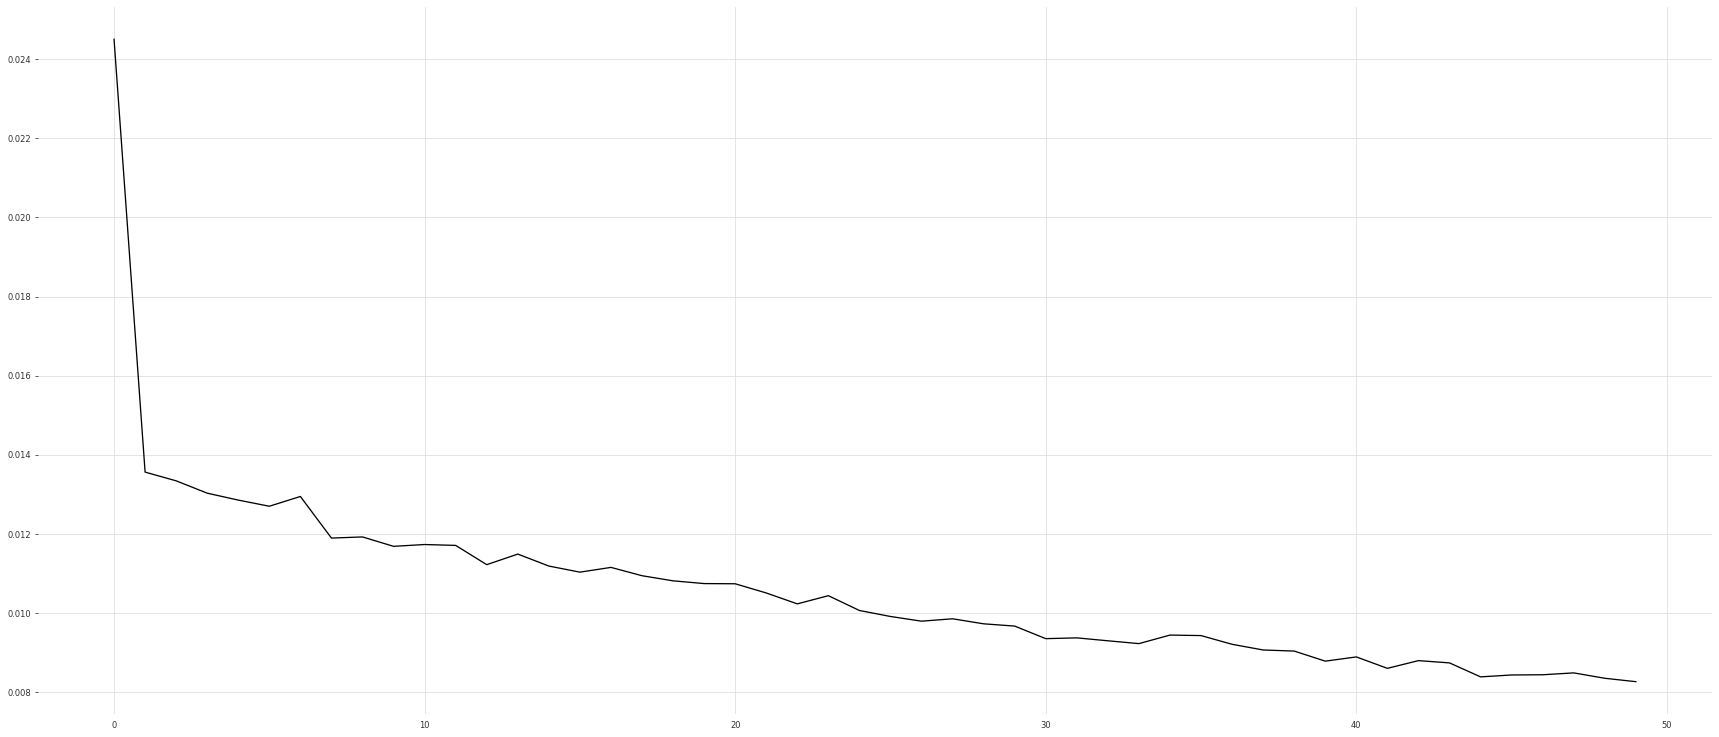

In [113]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [114]:
last_train_batch = scaled_train[-100:]

In [115]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [116]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 265ms/step


array([[0.66809815]], dtype=float32)

In [117]:
scaled_test[0]

array([0.67349961])

In [118]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 31ms/step


In [119]:
test_predictions

[array([0.66809815], dtype=float32),
 array([0.6390314], dtype=float32),
 array([0.61420983], dtype=float32),
 array([0.5914134], dtype=float32),
 array([0.57037616], dtype=float32),
 array([0.55058765], dtype=float32),
 array([0.5349187], dtype=float32),
 array([0.52294916], dtype=float32),
 array([0.51488125], dtype=float32),
 array([0.50967044], dtype=float32),
 array([0.50513875], dtype=float32),
 array([0.4998166], dtype=float32),
 array([0.4929375], dtype=float32),
 array([0.48441315], dtype=float32),
 array([0.47461516], dtype=float32),
 array([0.4640169], dtype=float32),
 array([0.45297265], dtype=float32),
 array([0.44181108], dtype=float32),
 array([0.4307431], dtype=float32),
 array([0.4198748], dtype=float32),
 array([0.40922415], dtype=float32),
 array([0.39875287], dtype=float32)]

In [120]:
test.head()

value
date               
2022-12-22 39160.30
2022-12-23 38502.18
2022-12-24 36227.07
2022-12-25 28116.81
2022-12-26 39846.63

In [121]:
true_predictions = scaler.inverse_transform(test_predictions)

In [122]:
test['Predictions'] = true_predictions

In [123]:
test.head()

value  Predictions
date                            
2022-12-22 39160.30     38923.78
2022-12-23 38502.18     37651.01
2022-12-24 36227.07     36564.13
2022-12-25 28116.81     35565.92
2022-12-26 39846.63     34644.74

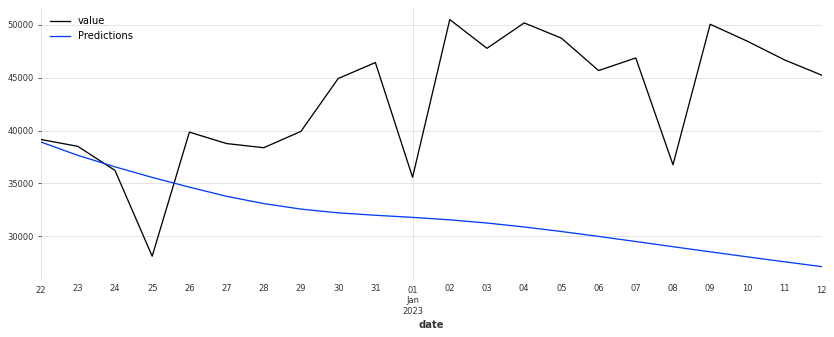

In [124]:
test.plot(figsize=(14,5))

In [127]:
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
mape=mean_absolute_percentage_error(test['value'],test['Predictions'])
print(f"Mean absolute percentage Error between actual and  predicted values: {mape:.3f}")

Mean absolute percentage Error between actual and  predicted values: 0.257


# Lets try different models using Darts.

In [155]:
df_darts=df.copy(deep=True)

In [156]:
df_darts

Day  Value (crores)
0   2021-05-01        18140.21
1   2021-05-02        13692.47
2   2021-05-03        20191.07
3   2021-05-04        20005.02
4   2021-05-05        19438.15
..         ...             ...
617 2023-01-08        36760.43
618 2023-01-09        50045.65
619 2023-01-10        48440.96
620 2023-01-11        46672.56
621 2023-01-12        45229.12

[622 rows x 2 columns]

In [157]:
df_darts.columns=['date','value']

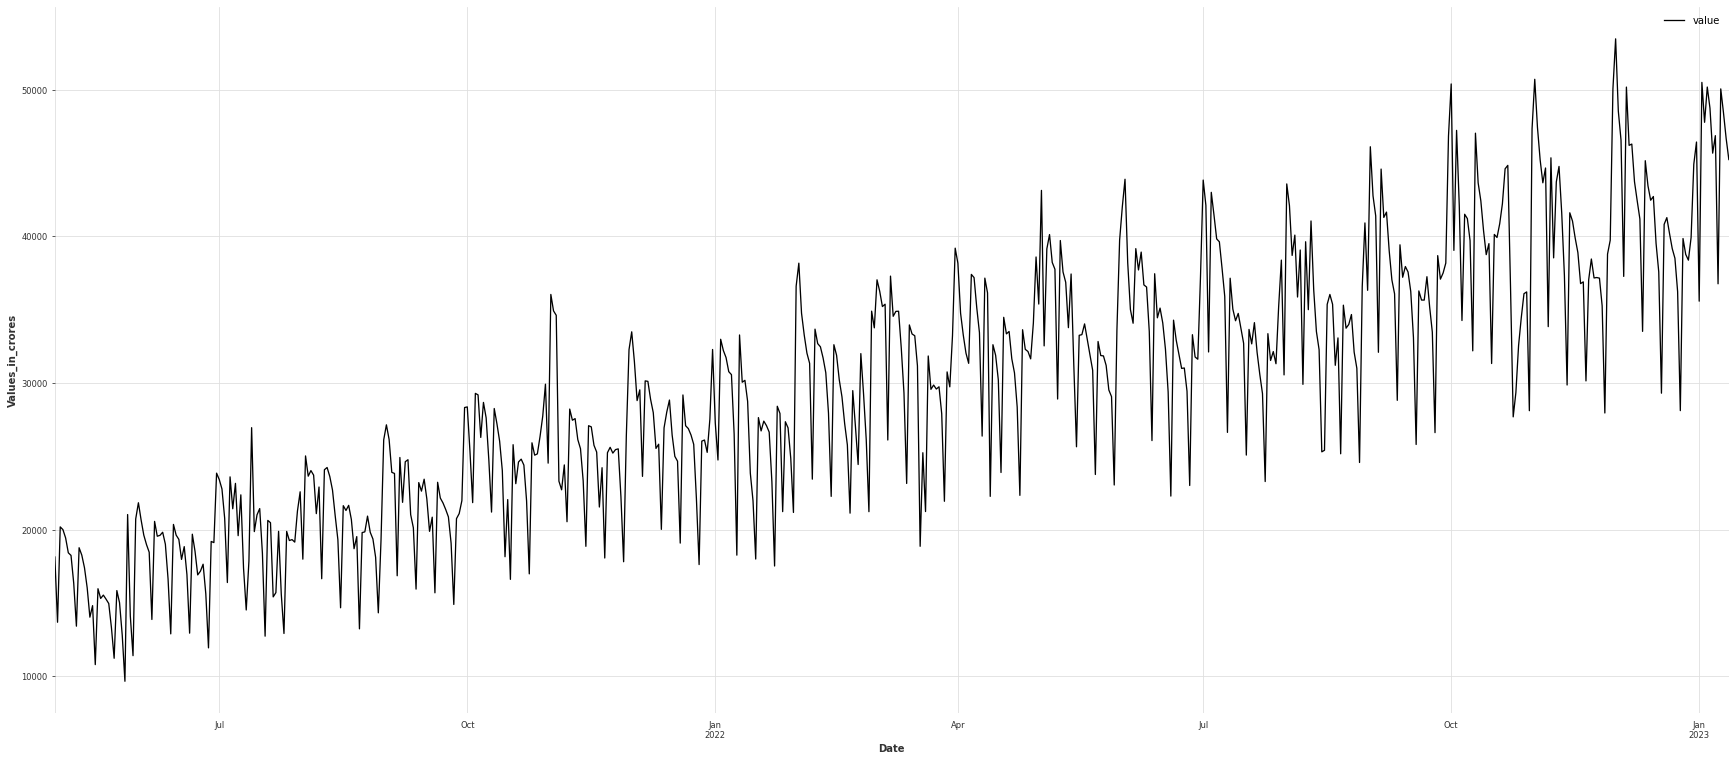

In [158]:
df_darts.plot(x='date',y='value')
plt.xlabel('Date')
plt.ylabel('Values_in_crores')
plt.show()

Darts

In [159]:
series=TimeSeries.from_dataframe(df_darts,time_col='date')

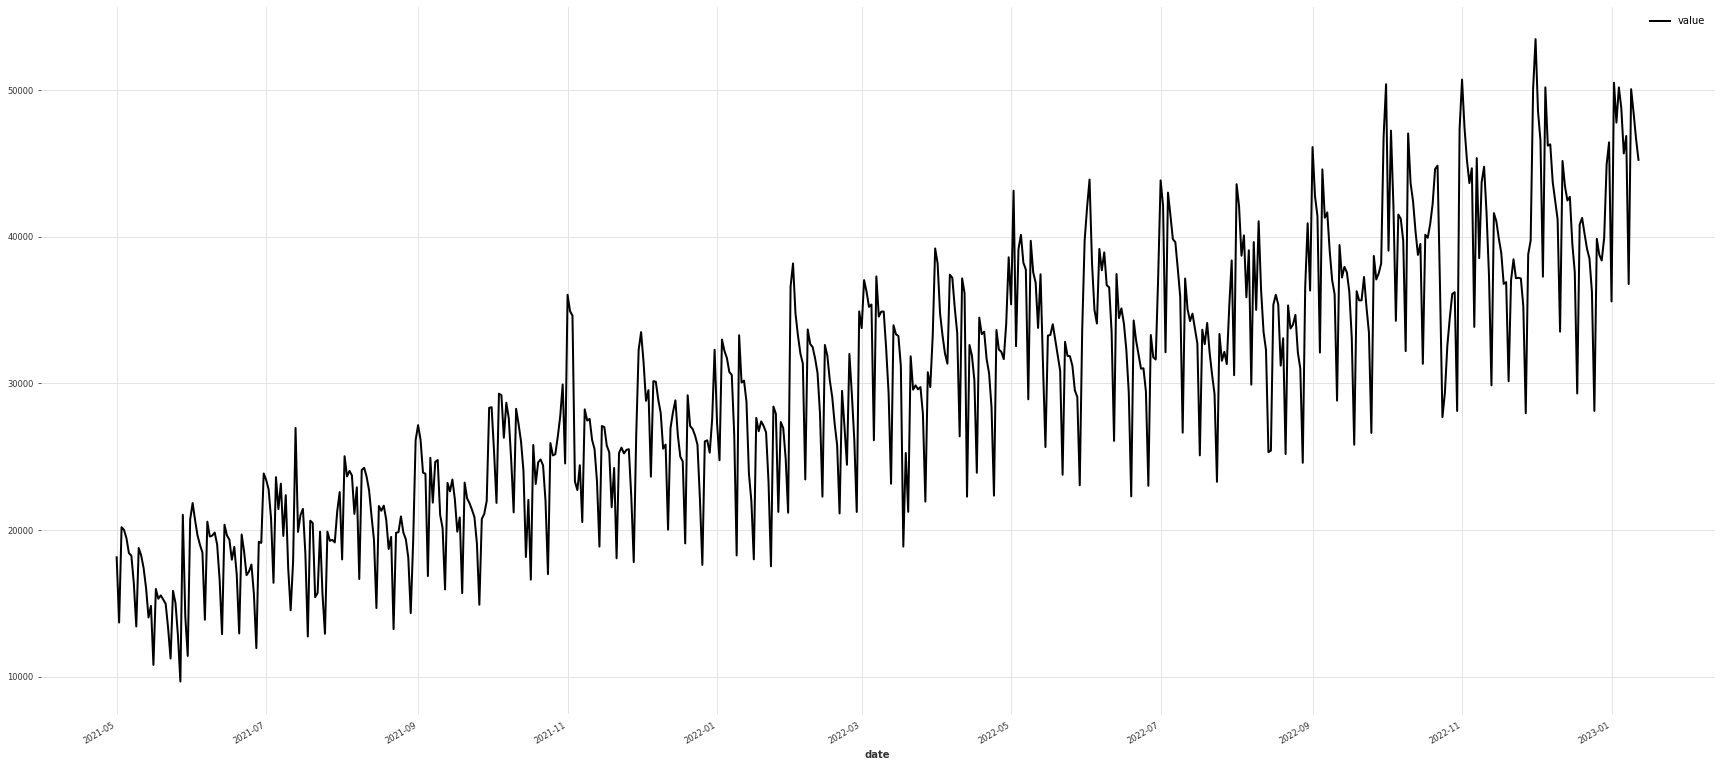

In [160]:
series.plot()

In [ ]:
# from darts.dataprocessing.transformers import Scaler
# scaler=Scaler()
# series_scaled=scaler.fit_transform(series)
# series_scaled.plot()

In [ ]:
# train, val =series_scaled.split_after(0.8)
# train.plot()
# val.plot()

In [ ]:
# # from darts.models import TBATS
# from darts.models import ExponentialSmoothing, AutoARIMA, Theta, RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
# from darts.utils.likelihood_models import LaplaceLikelihood, QuantileRegression


# def eval_model_scaled(model):
#     model.fit(train)
#     forecast = model.predict(len(val))
#     print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%   and RMSE:{rmse(val,forecast):.2f}.")

In [ ]:
# # Got some avarage result.
# eval_model_scaled(ExponentialSmoothing())
# eval_model_scaled(AutoARIMA())
# # eval_model_scaled(Theta())

In [ ]:
# # from darts.dataprocessing.transformers import Scaler
# # encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}
# # Forecasting with TBATS
# from darts.models import NBEATSModel
# model_NBEATSModel_scaled=NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)
# model_NBEATSModel_scaled.fit(train)
# pred_NBEATSModel_scaled=model_NBEATSModel_scaled.predict(len(val))
# series_scaled.plot()
# pred_NBEATSModel_scaled.plot()

In [ ]:
# val.plot()
# pred_NBEATSModel_scaled.plot()

In [ ]:
# eval_model_scaled(NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42))

In [161]:
training, validation = series.split_after(0.8)

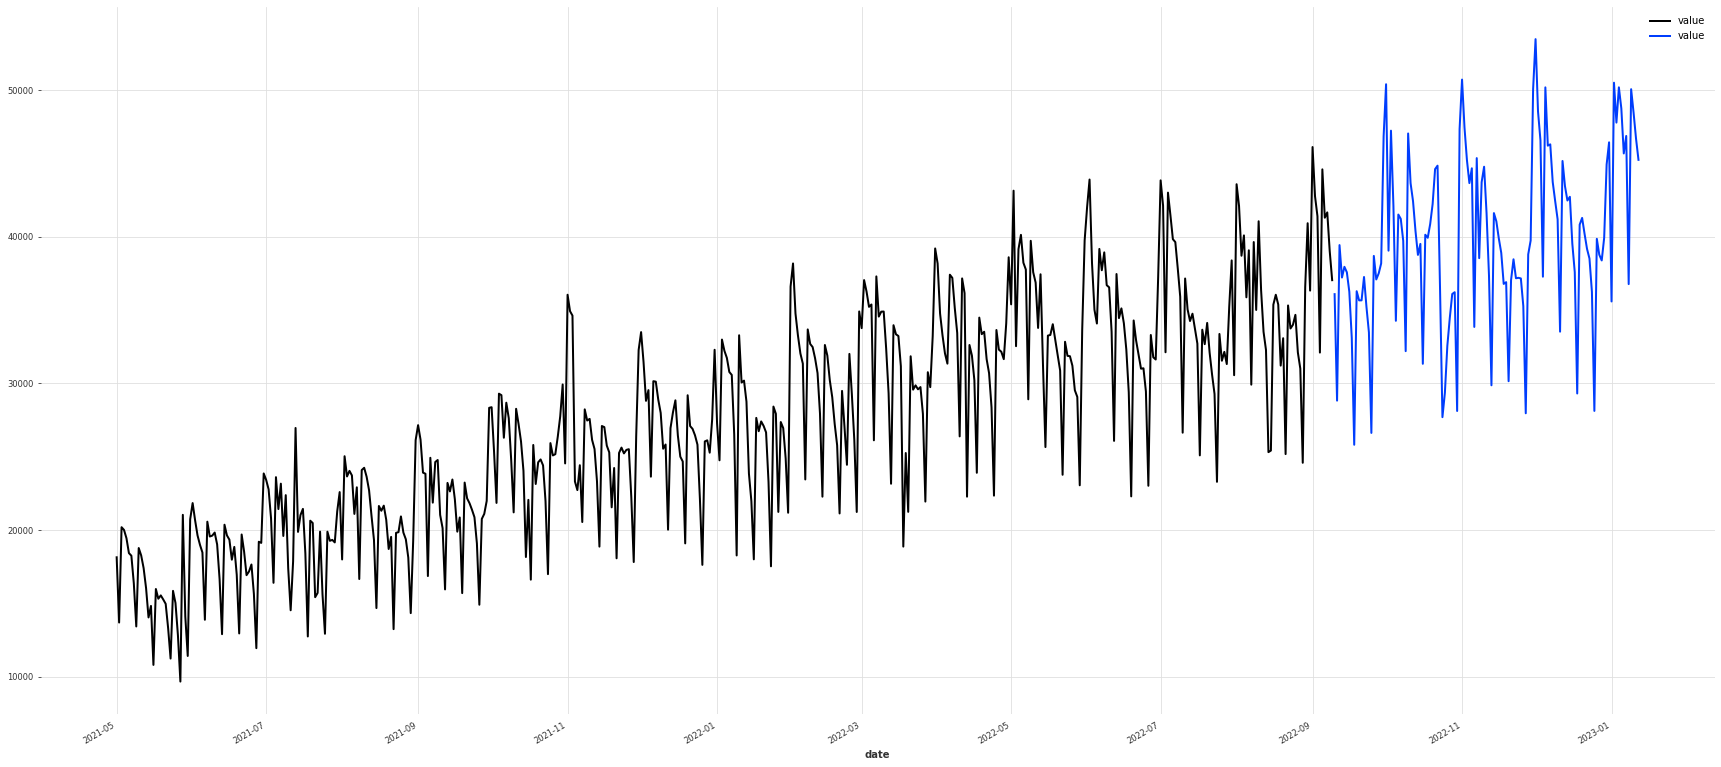

In [162]:
training.plot()
validation.plot()

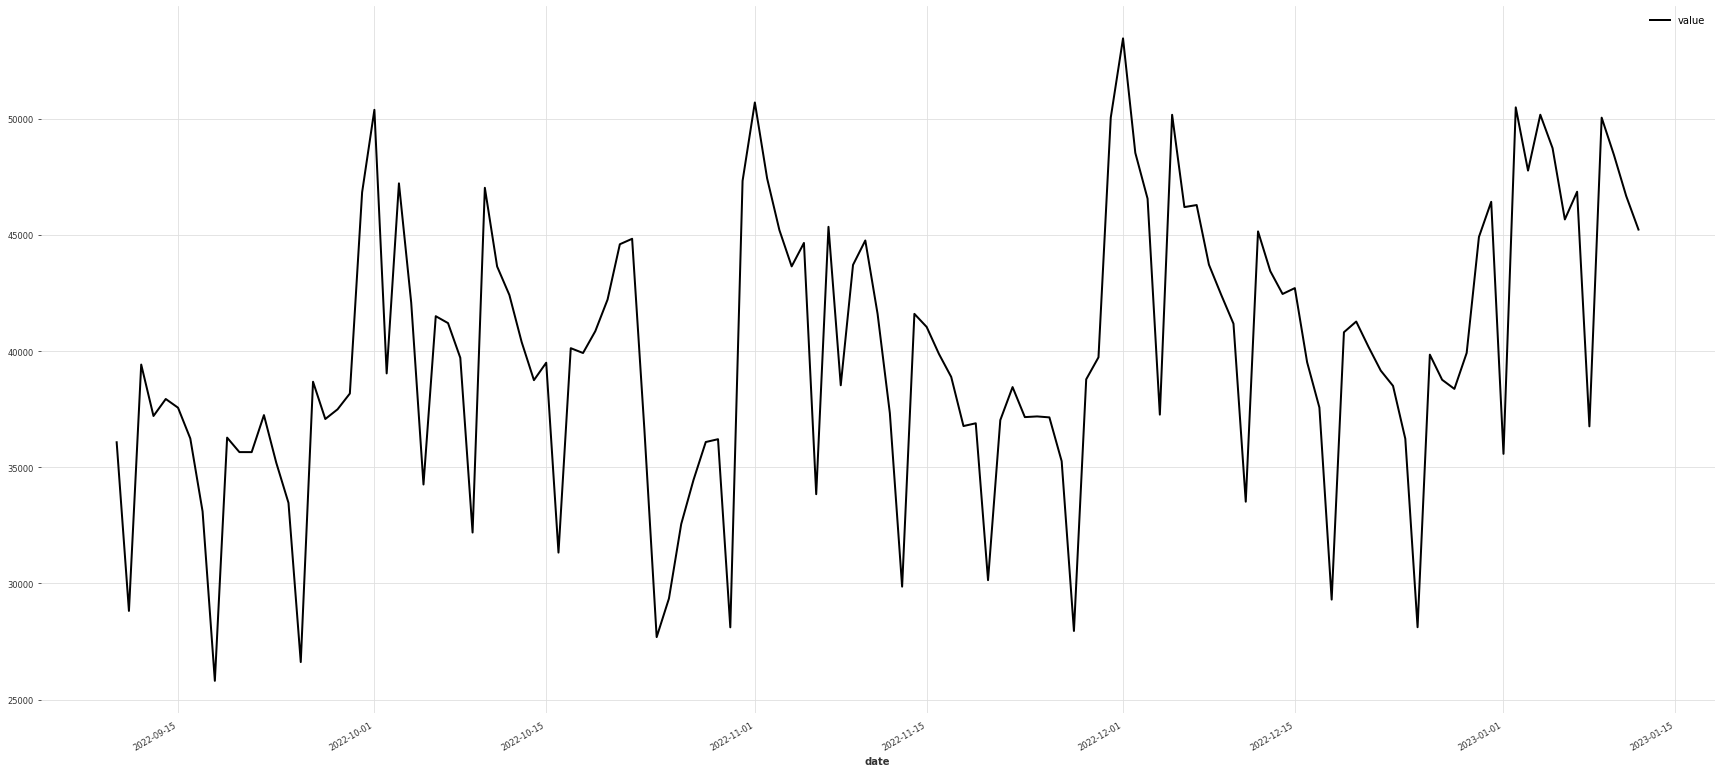

In [163]:
validation.plot()

In [ ]:
# model=TCNModel()

In [166]:
# from darts.models import TBATS
from darts.models import ExponentialSmoothing, AutoARIMA, Theta, RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel, NaiveDrift, NaiveSeasonal
from darts.utils.likelihood_models import LaplaceLikelihood, QuantileRegression


def eval_model(model):
    model.fit(training)
    forecast = model.predict(len(validation))
    print(f"model {model} obtains MAPE: {mape(validation, forecast):.2f}%.")

In [174]:
# Got some avarage result.
eval_model(ExponentialSmoothing())
eval_model(AutoARIMA())
eval_model(Theta(theta=5.8))
eval_model(NaiveDrift())
eval_model(NaiveSeasonal(K=12))
# eval_model(TBATS())
# eval_model(RNNModel(input_chunk_length=24))
# eval_model(TCNModel(input_chunk_length=24, output_chunk_length=12, random_state=42))
# eval_model(TransformerModel(input_chunk_length=24, output_chunk_length=12))
# eval_model(BlockRNNModel(input_chunk_length=24, output_chunk_length=12))


eval_model(NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MAPE: 10.12%.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


model Auto-ARIMA obtains MAPE: 11.63%.
model Theta(5.8) obtains MAPE: 9.34%.
model Naive drift model obtains MAPE: 11.60%.
model Naive seasonal model, with K=12 obtains MAPE: 14.84%.


INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.575    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

model <darts.models.forecasting.nbeats.NBEATSModel object at 0x7f8c6c33f1c0> obtains MAPE: 7.52%.


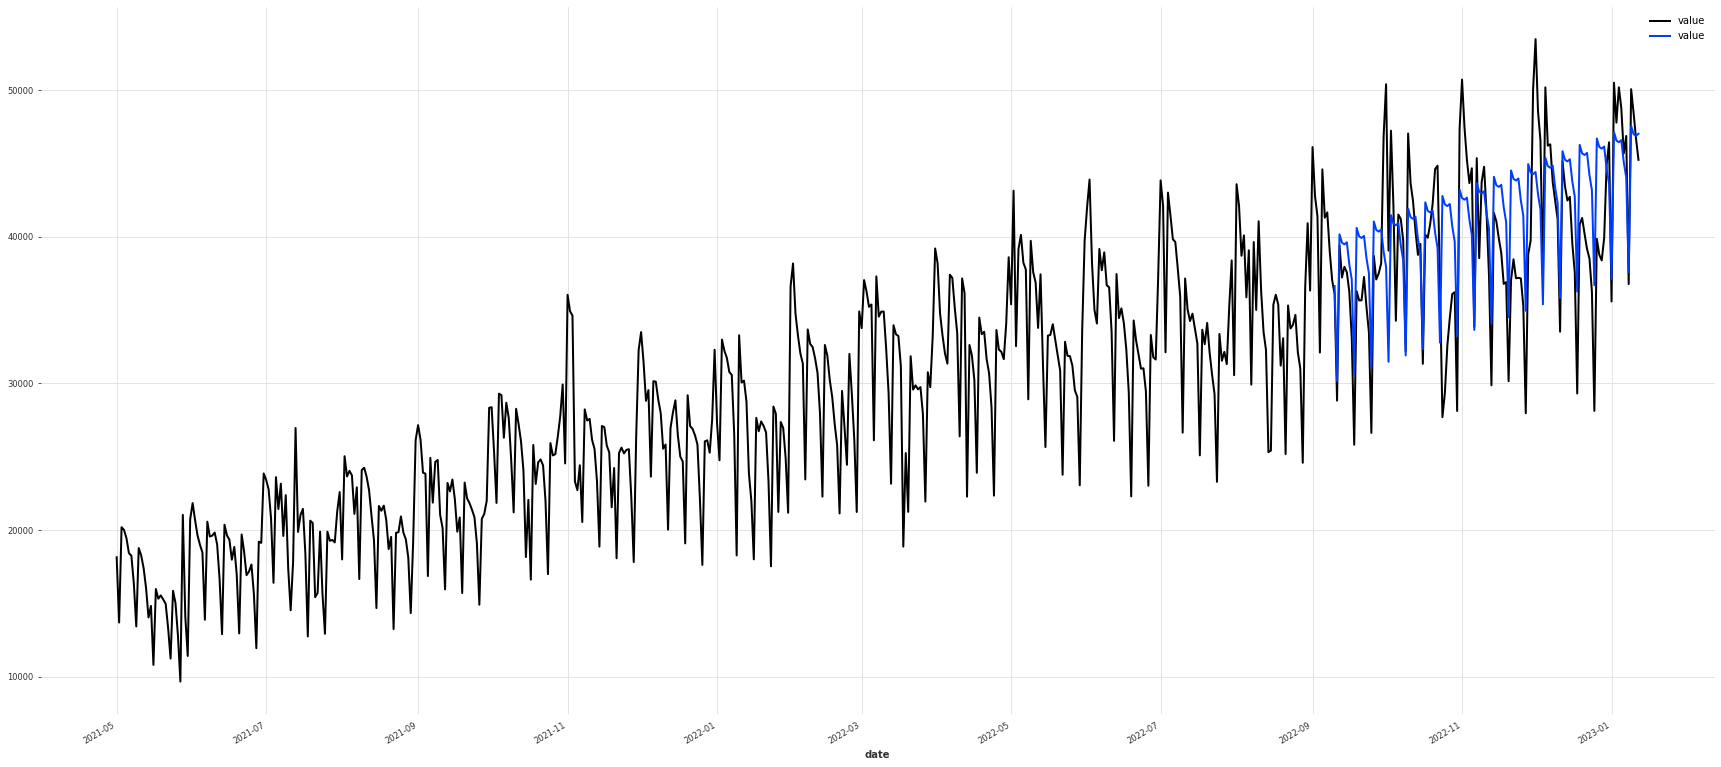

In [175]:
# Forecasting with Exponential smoothing.
from darts.models import ExponentialSmoothing
model_ES=ExponentialSmoothing()
model_ES.fit(training)
pred_ES=model_ES.predict(len(validation))
series.plot()
pred_ES.plot()

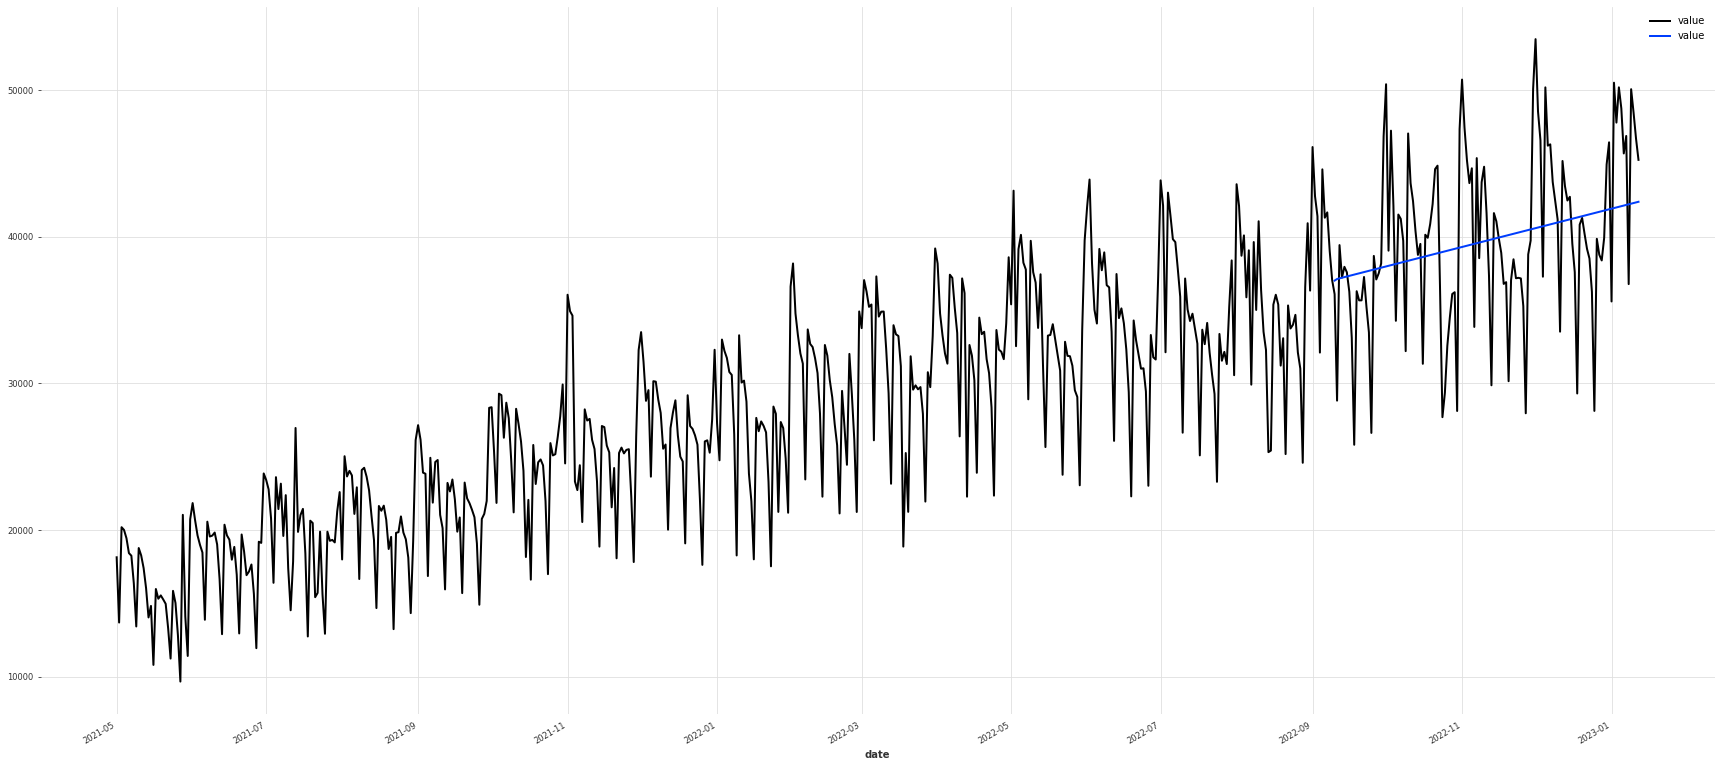

In [176]:
# Forecasting with AutoARIMA
from darts.models import AutoARIMA
model_Auto_Arima=AutoARIMA()
model_Auto_Arima.fit(training)
pred_Auto_Arima=model_Auto_Arima.predict(len(validation))
series.plot()
pred_Auto_Arima.plot()

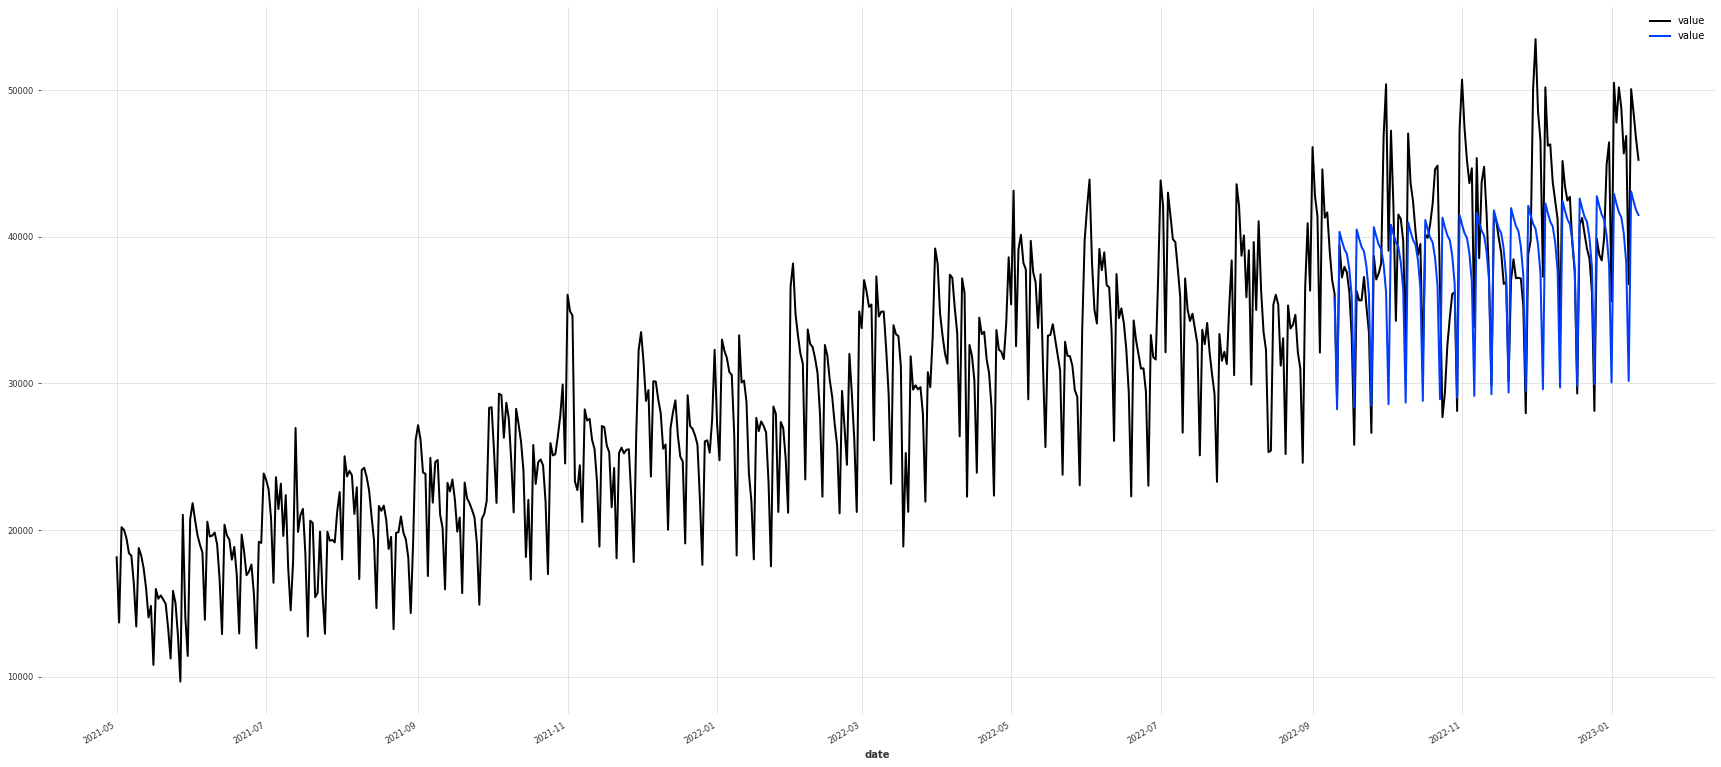

In [177]:
# Forecasting with Theta.
from darts.models import Theta
model_Theta=Theta()
model_Theta.fit(training)
pred_Theta=model_Theta.predict(len(validation))
series.plot()
pred_Theta.plot()

In [178]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(training)
    pred_theta = model.predict(len(validation))
    res = mape(validation, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [179]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(training)
pred_best_theta = best_theta_model.predict(len(validation))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(validation, pred_best_theta), best_theta
    )
)

The MAPE is: 9.34, with theta = 5.877551020408163.


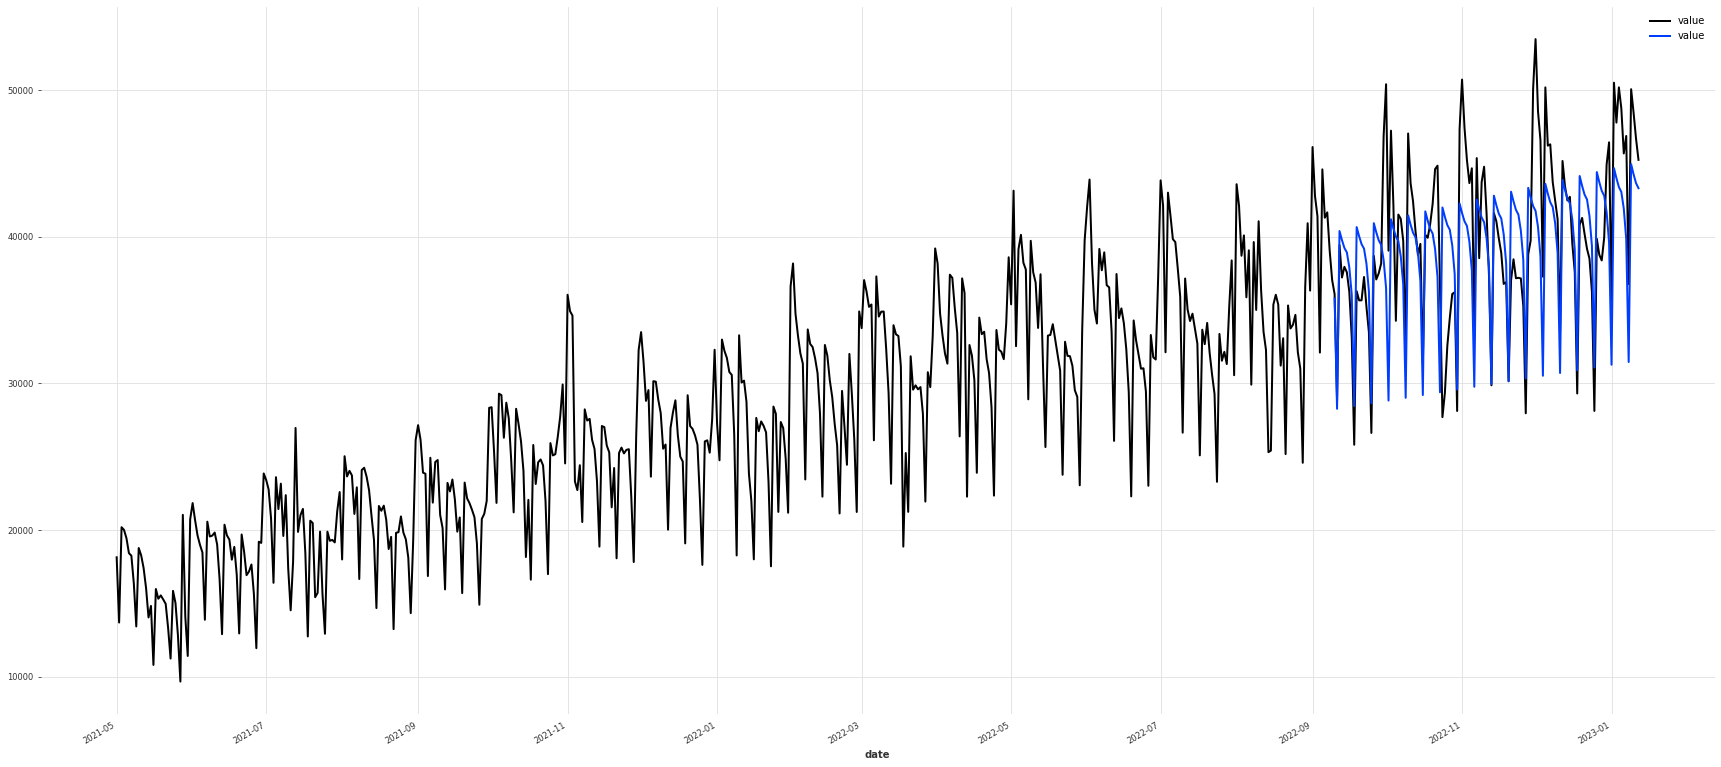

In [180]:
model_Theta_5=Theta(theta=5.8)
model_Theta_5.fit(training)
pred_Theta_5=model_Theta_5.predict(len(validation))

series.plot()
pred_Theta_5.plot()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.575    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

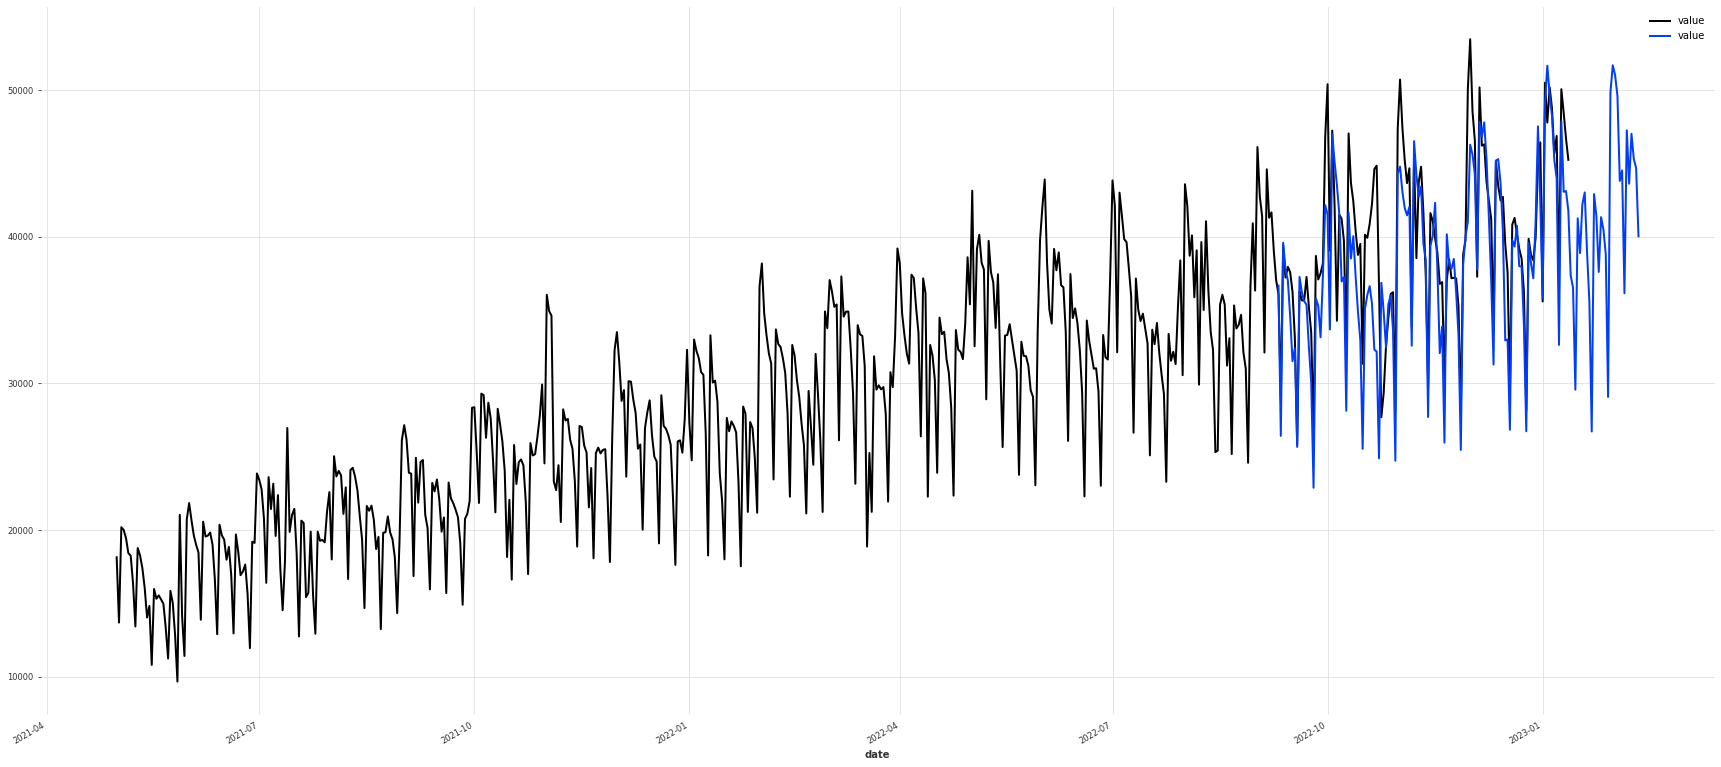

In [182]:
# Forecasting with NBEATSModel.
model_NBEATSModel=NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)
model_NBEATSModel.fit(training)
pred_NBEATSModel=model_NBEATSModel.predict(len(validation)+30)
series.plot()
pred_NBEATSModel.plot()

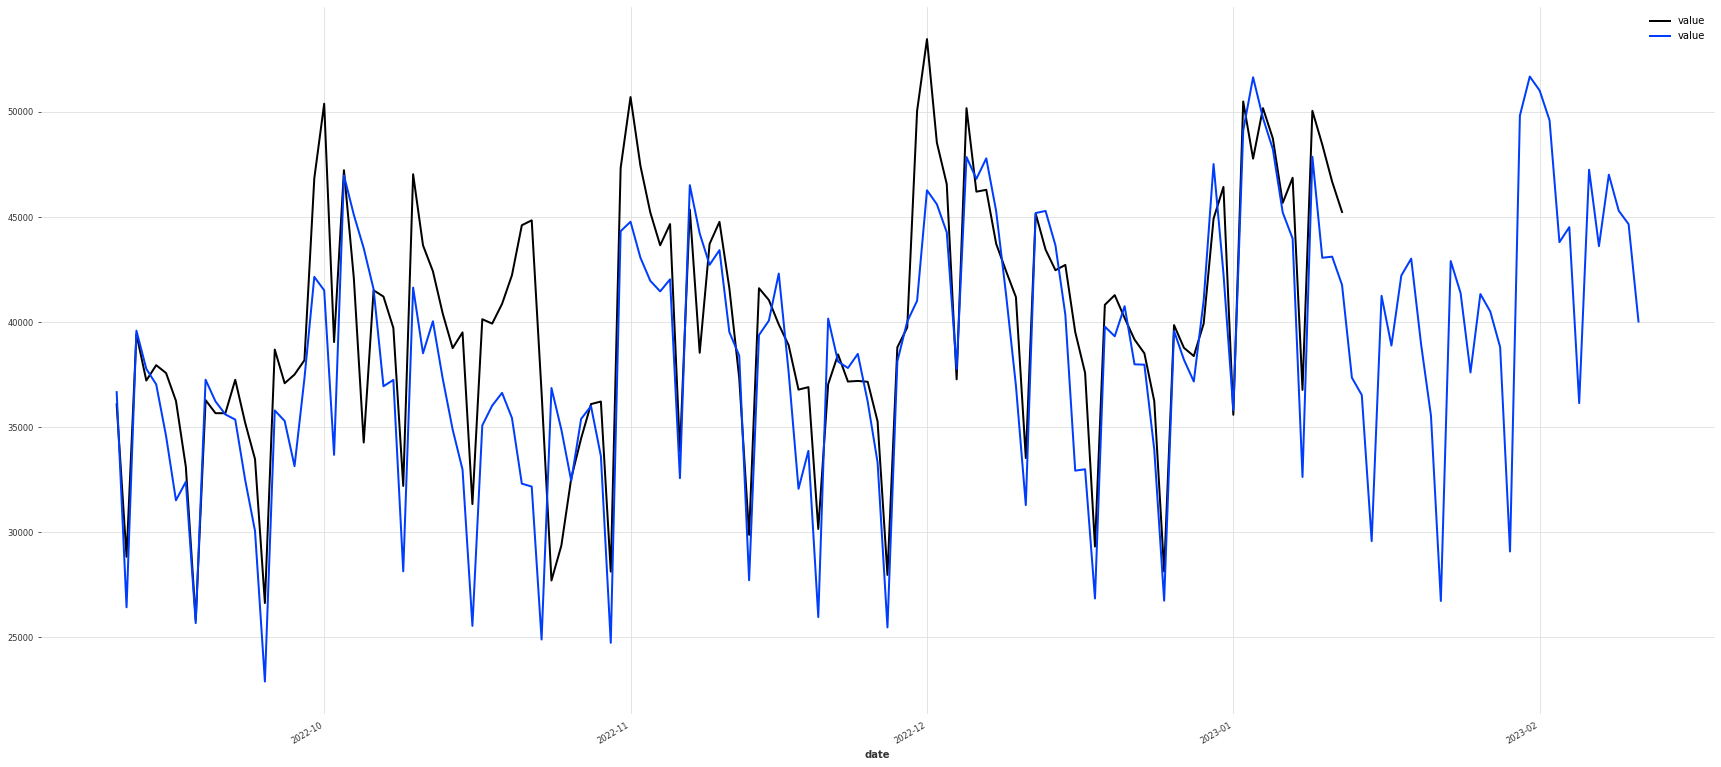

In [183]:
validation.plot()
pred_NBEATSModel.plot()

# Here we will now try FB Prophet model.

In [44]:
df.head()

date    value
0 2021-05-01 18140.21
1 2021-05-02 13692.47
2 2021-05-03 20191.07
3 2021-05-04 20005.02
4 2021-05-05 19438.15

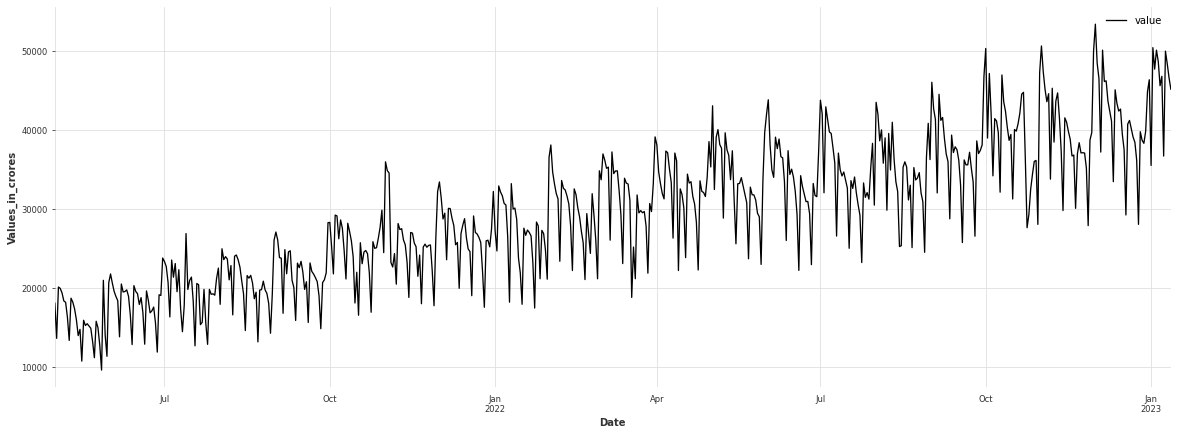

In [45]:
df.plot(x='date',y='value',figsize=(20,7))
plt.xlabel('Date')
plt.ylabel('Values_in_crores')
plt.show()

In [136]:
data_prophet=df.copy(deep=True)
data_prophet.columns=['ds','y']
data_prophet.head()

ds        y
0 2021-05-01 18140.21
1 2021-05-02 13692.47
2 2021-05-03 20191.07
3 2021-05-04 20005.02
4 2021-05-05 19438.15

In [47]:
model_prophet=Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)
model_prophet.fit(data_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80egp9mo/3a0ix209.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80egp9mo/8jqxhsrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44767', 'data', 'file=/tmp/tmp80egp9mo/3a0ix209.json', 'init=/tmp/tmp80egp9mo/8jqxhsrx.json', 'output', 'file=/tmp/tmp80egp9mo/prophet_model4nc152zx/prophet_model-20230216141908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
model_prophet.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [49]:
future_dates_prophet=model_prophet.make_future_dataframe(periods=30)

In [50]:
forecast_prophet=model_prophet.predict(future_dates_prophet)
forecast_prophet.head()

ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-05-01 16666.25     9271.75    27026.26     16666.25     16666.25   
1 2021-05-02 16709.47     2807.75    20821.28     16709.47     16709.47   
2 2021-05-03 16752.70    12107.49    29733.29     16752.70     16752.70   
3 2021-05-04 16795.92    11554.38    28463.63     16795.92     16795.92   
4 2021-05-05 16839.14    11069.45    28732.53     16839.14     16839.14   

   additive_terms  additive_terms_lower  additive_terms_upper   weekly  \
0         1410.20               1410.20               1410.20  -609.45   
1        -4737.95              -4737.95              -4737.95 -6665.56   
2         4125.10               4125.10               4125.10  2313.36   
3         3272.78               3272.78               3272.78  1599.06   
4         2938.71               2938.71               2938.71  1422.97   

   weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0       -609.45       -609.45 2019.65       2019.65       2019.65   
1      -6665.56      -6665.56 1927.60       1927.60       1927.60   
2       2313.36       2313.36 1811.74       1811.74       1811.74   
3       1599.06       1599.06 1673.72       1673.72       1673.72   
4       1422.97       1422.97 1515.73       1515.73       1515.73   

   multiplicative_terms  multiplicative_terms_lower  \
0                  0.00                        0.00   
1                  0.00                        0.00   
2                  0.00                        0.00   
3                  0.00                        0.00   
4                  0.00                        0.00   

   multiplicative_terms_upper     yhat  
0                        0.00 18076.46  
1                        0.00 11971.52  
2                        0.00 20877.79  
3                        0.00 20068.70  
4                        0.00 19777.84

In [51]:
forecast_prophet[['ds','yhat','yhat_lower','yhat_upper']].head()

ds     yhat  yhat_lower  yhat_upper
0 2021-05-01 18076.46     9271.75    27026.26
1 2021-05-02 11971.52     2807.75    20821.28
2 2021-05-03 20877.79    12107.49    29733.29
3 2021-05-04 20068.70    11554.38    28463.63
4 2021-05-05 19777.84    11069.45    28732.53

In [52]:
forecast_prophet_train_data=forecast_prophet.loc[:len(forecast_prophet)-31,['ds','yhat','yhat_lower','yhat_upper']]

In [53]:
data_prophet.tail()

ds        y
617 2023-01-08 36760.43
618 2023-01-09 50045.65
619 2023-01-10 48440.96
620 2023-01-11 46672.56
621 2023-01-12 45229.12

In [54]:
forecast_prophet_train_data.tail()

ds     yhat  yhat_lower  yhat_upper
617 2023-01-08 36563.51    28724.76    45716.85
618 2023-01-09 45637.69    36746.63    55136.14
619 2023-01-10 44995.56    36380.25    53575.92
620 2023-01-11 44867.92    36573.52    52499.46
621 2023-01-12 44865.31    35968.70    53281.82

In [60]:
import math
from sklearn.metrics import mean_absolute_percentage_error
print(f"Mean absolute percentage Error between actual and  predicted values: {mean_absolute_percentage_error(forecast_prophet_train_data['yhat'],data_prophet['y']):.3f}")

Mean absolute percentage Error between actual and  predicted values: 0.094


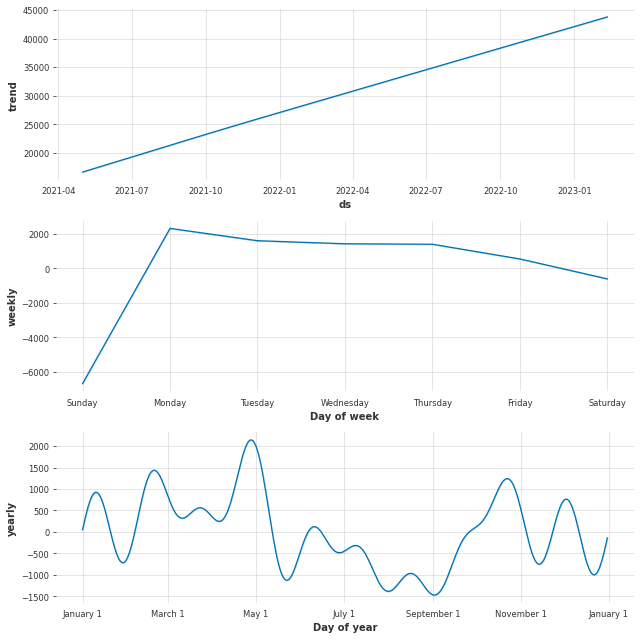

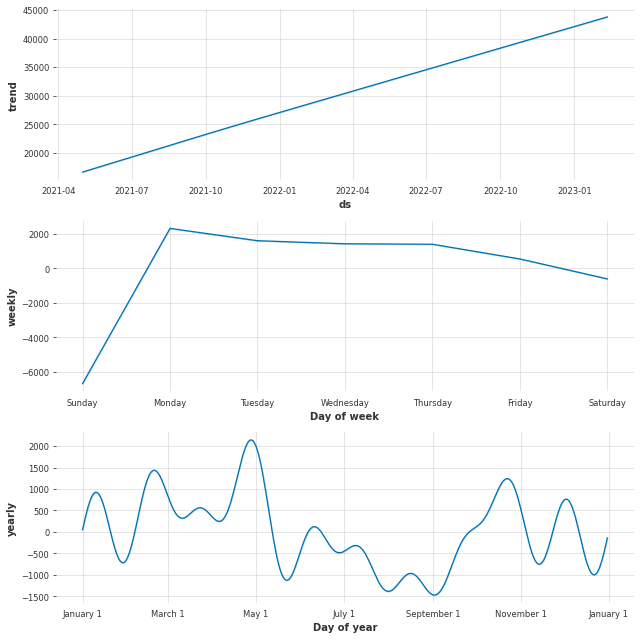

In [66]:
model_prophet.plot_components(forecast_prophet)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model_prophet,forecast_prophet,figsize=(1500,900))

In [67]:
plot_components_plotly(model_prophet,forecast_prophet)

In [68]:
forecast_prophet_train_data.head()

ds     yhat  yhat_lower  yhat_upper
0 2021-05-01 18076.46     9271.75    27026.26
1 2021-05-02 11971.52     2807.75    20821.28
2 2021-05-03 20877.79    12107.49    29733.29
3 2021-05-04 20068.70    11554.38    28463.63
4 2021-05-05 19777.84    11069.45    28732.53

In [69]:
# Merge actual and predicted values
performance = pd.merge(data_prophet, forecast_prophet_train_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [70]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
performance['anomaly'].value_counts()

0    611
1     11
Name: anomaly, dtype: int64

In [71]:
# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

ds        y     yhat  yhat_lower  yhat_upper  anomaly
186 2021-11-03 34613.47 26330.36    17561.12    34555.96        1
321 2022-03-18 18869.04 31246.56    22277.26    41242.09        1
347 2022-04-13 22271.87 33322.14    24586.08    41891.91        1
397 2022-06-02 43887.84 34373.17    25995.64    43287.44        1
426 2022-07-01 43831.02 34637.86    25355.76    43616.76        1
471 2022-08-15 25414.14 37737.44    28429.88    47346.65        1
518 2022-10-01 50382.75 37834.66    28910.39    47223.80        1
541 2022-10-24 27690.79 42821.00    33608.38    50965.62        1
542 2022-10-25 29351.82 42119.08    33040.98    50629.14        1
549 2022-11-01 50700.08 41765.92    33370.68    50222.81        1
579 2022-12-01 53457.06 42967.52    33549.63    51887.01        1

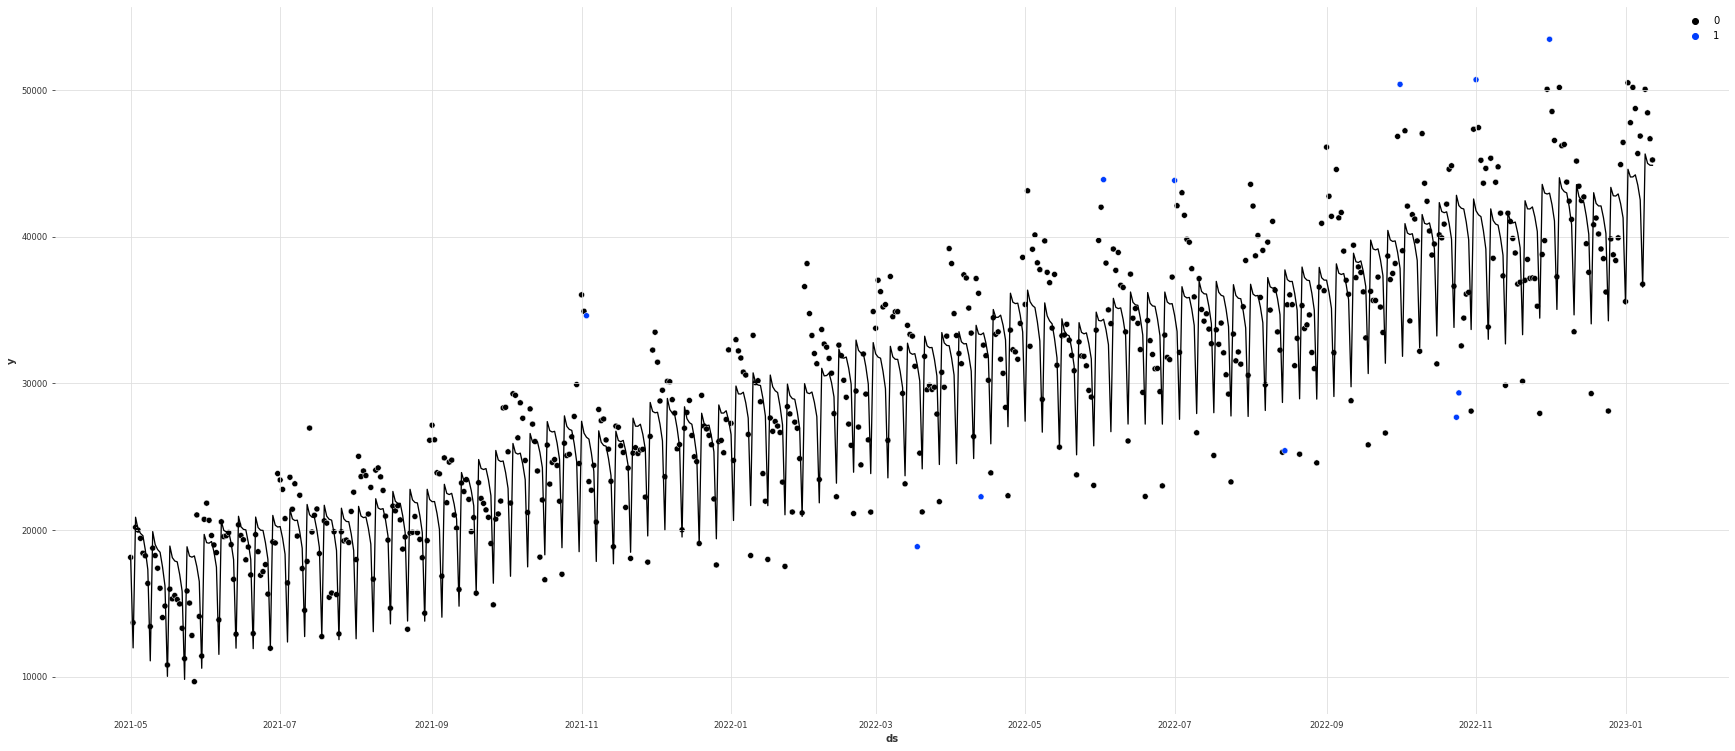

In [72]:
# Visualize the anomalies
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize']=30,13
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')